In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


ModuleNotFoundError: No module named 'scipy._lib'

# def

In [2]:
#normalize
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

#scale back to the true range
def true_range(df, x, response):
    X = (x * (df[response].max() - df[response].min())) + df[response].min()
    return X

#rolling windows
def train_windows(df, response, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day+1):
        #扣掉response
        #記得最後一行要放response
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day][response]))
    return np.array(X_train), np.array(Y_train)

#Moving Average  
def MA(df, n):  
    MA = df.rolling(n).mean()
    return MA

#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='linear'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew
    

In [3]:
df = pd.read_csv('./data/3406.csv')
df['spread1'] = df['Ask1'] - df['Bid1']
df['spread2'] = df['Ask2'] - df['Bid2']
df['spread3'] = df['Ask3'] - df['Bid3']
df['spread4'] = df['Ask4'] - df['Bid4']
df['spread5'] = df['Ask5'] - df['Bid5']
df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
df['a51_diff'] = df['Ask5'] - df['Ask1']
df['b15_diff'] = df['Bid1'] - df['Bid5']
df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a32_diff_abs'] = np.abs(df['Ask3'] - df['Ask2'])
df['a43_diff_abs'] = np.abs(df['Ask4'] - df['Ask3'])
df['a54_diff_abs'] = np.abs(df['Ask5'] - df['Ask4'])
df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
#1 tick
df['da1_dt_1'] = df['Ask1'] - df['Ask1'].shift(1)
df['da2_dt_1'] = df['Ask2'] - df['Ask2'].shift(1)
df['da3_dt_1'] = df['Ask3'] - df['Ask3'].shift(1)
df['da4_dt_1'] = df['Ask4'] - df['Ask4'].shift(1)
df['da5_dt_1'] = df['Ask5'] - df['Ask5'].shift(1)
df['db1_dt_1'] = df['Bid1'] - df['Bid1'].shift(1)
df['db2_dt_1'] = df['Bid2'] - df['Bid2'].shift(1)
df['db3_dt_1'] = df['Bid3'] - df['Bid3'].shift(1)
df['db4_dt_1'] = df['Bid4'] - df['Bid4'].shift(1)
df['db5_dt_1'] = df['Bid5'] - df['Bid5'].shift(1)
#5 ticks
df['da1_dt_5'] = df['Ask1'] - df['Ask1'].shift(5)
df['da2_dt_5'] = df['Ask2'] - df['Ask2'].shift(5)
df['da3_dt_5'] = df['Ask3'] - df['Ask3'].shift(5)
df['da4_dt_5'] = df['Ask4'] - df['Ask4'].shift(5)
df['da5_dt_5'] = df['Ask5'] - df['Ask5'].shift(5)
df['db1_dt_5'] = df['Bid1'] - df['Bid1'].shift(5)
df['db2_dt_5'] = df['Bid2'] - df['Bid2'].shift(5)
df['db3_dt_5'] = df['Bid3'] - df['Bid3'].shift(5)
df['db4_dt_5'] = df['Bid4'] - df['Bid4'].shift(5)
df['db5_dt_5'] = df['Bid5'] - df['Bid5'].shift(5)
##10 ticks
df['da1_dt_10'] = df['Ask1'] - df['Ask1'].shift(10)
df['da2_dt_10'] = df['Ask2'] - df['Ask2'].shift(10)
df['da3_dt_10'] = df['Ask3'] - df['Ask3'].shift(10)
df['da4_dt_10'] = df['Ask4'] - df['Ask4'].shift(10)
df['da5_dt_10'] = df['Ask5'] - df['Ask5'].shift(10)
df['db1_dt_10'] = df['Bid1'] - df['Bid1'].shift(10)
df['db2_dt_10'] = df['Bid2'] - df['Bid2'].shift(10)
df['db3_dt_10'] = df['Bid3'] - df['Bid3'].shift(10)
df['db4_dt_10'] = df['Bid4'] - df['Bid4'].shift(10)
df['db5_dt_10'] = df['Bid5'] - df['Bid5'].shift(10)
#1 tick
df['daq1_dt_1'] = df['AskQty1'] - df['AskQty1'].shift(1)
df['daq2_dt_1'] = df['AskQty2'] - df['AskQty2'].shift(1)
df['daq3_dt_1'] = df['AskQty3'] - df['AskQty3'].shift(1)
df['daq4_dt_1'] = df['AskQty4'] - df['AskQty4'].shift(1)
df['daq5_dt_1'] = df['AskQty5'] - df['AskQty5'].shift(1)
df['dbq1_dt_1'] = df['BidQty1'] - df['BidQty1'].shift(1)
df['dbq2_dt_1'] = df['BidQty2'] - df['BidQty2'].shift(1)
df['dbq3_dt_1'] = df['BidQty3'] - df['BidQty3'].shift(1)
df['dbq4_dt_1'] = df['BidQty4'] - df['BidQty4'].shift(1)
df['dbq5_dt_1'] = df['BidQty5'] - df['BidQty5'].shift(1)
#5 ticks
df['daq1_dt_5'] = df['AskQty1'] - df['AskQty1'].shift(5)
df['daq2_dt_5'] = df['AskQty2'] - df['AskQty2'].shift(5)
df['daq3_dt_5'] = df['AskQty3'] - df['AskQty3'].shift(5)
df['daq4_dt_5'] = df['AskQty4'] - df['AskQty4'].shift(5)
df['daq5_dt_5'] = df['AskQty5'] - df['AskQty5'].shift(5)
df['dbq1_dt_5'] = df['BidQty1'] - df['BidQty1'].shift(5)
df['dbq2_dt_5'] = df['BidQty2'] - df['BidQty2'].shift(5)
df['dbq3_dt_5'] = df['BidQty3'] - df['BidQty3'].shift(5)
df['dbq4_dt_5'] = df['BidQty4'] - df['BidQty4'].shift(5)
df['dbq5_dt_5'] = df['BidQty5'] - df['BidQty5'].shift(5)
#10 ticks
df['daq1_dt_10'] = df['AskQty1'] - df['AskQty1'].shift(10)
df['daq2_dt_10'] = df['AskQty2'] - df['AskQty2'].shift(10)
df['daq3_dt_10'] = df['AskQty3'] - df['AskQty3'].shift(10)
df['daq4_dt_10'] = df['AskQty4'] - df['AskQty4'].shift(10)
df['daq5_dt_10'] = df['AskQty5'] - df['AskQty5'].shift(10)
df['dbq1_dt_10'] = df['BidQty1'] - df['BidQty1'].shift(10)
df['dbq2_dt_10'] = df['BidQty2'] - df['BidQty2'].shift(10)
df['dbq3_dt_10'] = df['BidQty3'] - df['BidQty3'].shift(10)
df['dbq4_dt_10'] = df['BidQty4'] - df['BidQty4'].shift(10)
df['dbq5_dt_10'] = df['BidQty5'] - df['BidQty5'].shift(10)
#response 放在最後一行
df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
#drop nan
df = df.dropna()
df = df.reset_index(drop = True)
#b43_diff_abs and b54_diff_abs are all same values -> drop
#df = df.drop(['b43_diff_abs'], axis = 1)
#df = df.drop(['b54_diff_abs'], axis = 1)
from datetime import datetime
df['TxTime'] = pd.to_datetime(df['TxTime'])
df['TxTime'] = [str(x)[0:10] for x in df['TxTime']]
#some index's ask1 = 0, we change that mid1 to bid1
idx = df[df['Ask1'] == 0].index
for i in idx:
    df['mid1'].iloc[i] = df['Bid1'].iloc[i]
#3/23 3/24 data有缺值 -> drop
df = df[df['TxTime'] != '2020-03-23']
df = df[df['TxTime'] != '2020-03-24']
df = df.reset_index(drop = True)
#drop TxTime
df2 = df.drop(['TxTime'], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
train_5t = pd.read_csv('./data/train_5t.csv')
test_5t = pd.read_csv('./data/test_5t.csv')
#已實現損益
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#未實現損益
df['unrealized'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df['holding'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#drop 4/15 的 last tick
df_test = df.iloc[282250: ]
#為了可以被5整除
df_train = df.iloc[0:282250]
#1~10 pred 11, hence start from 11
df_train = df_train.iloc[10:, :]
df_test = df_test.iloc[10:, :]
#reset index
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
#calculate pred return
df_train['pred_mid'] = train_5t[['0']]
#df_train['mid_shift'] = df_train['pred_mid'].shift(1)
df_test['pred_mid'] = test_5t[['0']]

In [5]:
df_train['mid_5_shift'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
for i in range(int(int(len(df_train)) / 5)):
    df_train['mid_5_shift'].iloc[5 * i] = df_train['pred_mid'].iloc[(5 * i) + 4]
df_train['pred_return'] = df_train['mid_5_shift'] / df_train['pred_mid'] - 1
for i in range(len(df_train)):
    if df_train['pred_return'].iloc[i] == -1:
        df_train['pred_return'].iloc[i] = 0

In [6]:
df_test['mid_5_shift'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
for i in range(int(int(len(df_test)) / 5)):
    df_test['mid_5_shift'].iloc[5 * i] = df_test['pred_mid'].iloc[(5 * i) + 4]
df_test['pred_return'] = df_test['mid_5_shift'] / df_test['pred_mid'] - 1
for i in range(len(df_test)):
    if df_test['pred_return'].iloc[i] == -1:
        df_test['pred_return'].iloc[i] = 0

In [7]:
#setting parameters
import itertools 
long_side, short_side, stop_1 = [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004], [-0.001, -0.0015, -0.002, -0.0025, -0.003, -0.0035, -0.004], [-0.015, -0.02, -0.025]
paras = list(itertools.product(long_side, short_side, stop_1))
paras

[(0.001, -0.001, -0.015),
 (0.001, -0.001, -0.02),
 (0.001, -0.001, -0.025),
 (0.001, -0.0015, -0.015),
 (0.001, -0.0015, -0.02),
 (0.001, -0.0015, -0.025),
 (0.001, -0.002, -0.015),
 (0.001, -0.002, -0.02),
 (0.001, -0.002, -0.025),
 (0.001, -0.0025, -0.015),
 (0.001, -0.0025, -0.02),
 (0.001, -0.0025, -0.025),
 (0.001, -0.003, -0.015),
 (0.001, -0.003, -0.02),
 (0.001, -0.003, -0.025),
 (0.001, -0.0035, -0.015),
 (0.001, -0.0035, -0.02),
 (0.001, -0.0035, -0.025),
 (0.001, -0.004, -0.015),
 (0.001, -0.004, -0.02),
 (0.001, -0.004, -0.025),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.001, -0.02),
 (0.0015, -0.001, -0.025),
 (0.0015, -0.0015, -0.015),
 (0.0015, -0.0015, -0.02),
 (0.0015, -0.0015, -0.025),
 (0.0015, -0.002, -0.015),
 (0.0015, -0.002, -0.02),
 (0.0015, -0.002, -0.025),
 (0.0015, -0.0025, -0.015),
 (0.0015, -0.0025, -0.02),
 (0.0015, -0.0025, -0.025),
 (0.0015, -0.003, -0.015),
 (0.0015, -0.003, -0.02),
 (0.0015, -0.003, -0.025),
 (0.0015, -0.0035, -0.015),
 (0.0015, -0.0035,

In [8]:
#colab lstm_mid1_5t
#adding hard stop and 1->0 / -1->0 stop
#main strategy (train set)
#record transaction
transaction_history1 = {}
#record equity values
equity_value_1 = pd.DataFrame()
#record each returns
each_return1 = pd.DataFrame()
#record unrealized gain
unrealized_1 = pd.DataFrame()
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['pred_return'].iloc[j] > paras[l][0]:
            #long side
            df_train['side'].iloc[j] = 1
        elif df_train['pred_return'].iloc[j] < paras[l][1]:
            #short side
            df_train['side'].iloc[j] = -1
    date_idx = df_train['TxTime'].unique()
    #紀錄已實現
    equity_value1 = pd.DataFrame()
    #紀錄未實現
    unrealized1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]) or (df['pred_return'].iloc[i] < - paras[l][0] / 2): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and (((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]) or (df['pred_return'].iloc[i] > - paras[l][1] / 2)): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
        unrealized1 = pd.concat([unrealized1, df['unrealized']])
    #concat
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site

In [15]:
equity_value_1.iloc[-1][equity_value_1.iloc[-1] > 0].sort_values(ascending=False).index.tolist()

[(0.002, -0.004, -0.025),
 (0.002, -0.0035, -0.025),
 (0.0025, -0.004, -0.025),
 (0.002, -0.004, -0.015),
 (0.002, -0.004, -0.02),
 (0.002, -0.003, -0.025),
 (0.0025, -0.0035, -0.025),
 (0.002, -0.0035, -0.015),
 (0.002, -0.0035, -0.02),
 (0.0025, -0.003, -0.025),
 (0.0025, -0.004, -0.015),
 (0.004, -0.004, -0.025),
 (0.0025, -0.004, -0.02),
 (0.0035, -0.004, -0.025),
 (0.003, -0.004, -0.025),
 (0.002, -0.003, -0.015),
 (0.002, -0.003, -0.02),
 (0.002, -0.0025, -0.025),
 (0.0025, -0.0035, -0.015),
 (0.004, -0.0035, -0.025),
 (0.0025, -0.0035, -0.02),
 (0.002, -0.0025, -0.015),
 (0.003, -0.0035, -0.025),
 (0.0035, -0.0035, -0.025),
 (0.002, -0.0025, -0.02),
 (0.0025, -0.003, -0.015),
 (0.004, -0.003, -0.025),
 (0.0025, -0.003, -0.02),
 (0.004, -0.004, -0.015),
 (0.004, -0.004, -0.02),
 (0.0025, -0.0025, -0.025),
 (0.003, -0.003, -0.025),
 (0.0035, -0.003, -0.025),
 (0.0015, -0.0035, -0.025),
 (0.003, -0.004, -0.015),
 (0.0035, -0.004, -0.015),
 (0.002, -0.002, -0.015),
 (0.003, -0.004, 

In [10]:
equity_value_1.columns = paras

In [30]:
for i in equity_value_1.iloc[-1].sort_values(ascending=False).index.to_list():
    print(i)
    performance(equity_value_1[[i]], transaction_history1[i])

(0.002, -0.004, -0.025)
return: 0.2199952739765666
std: 0.05810455812167254
sharp ratio: 3.6967026498468396
trades: 14.0
odds ratio: 0.5714285714285714
mdd: 0.01993670259000596
skewness: -1.1422594793016863
(0.002, -0.0035, -0.025)
return: 0.19331224564841787
std: 0.05464121936934641
sharp ratio: 3.4426802296792878
trades: 16.0
odds ratio: 0.5
mdd: 0.01993670259000596
skewness: -1.0090869142442298
(0.0025, -0.004, -0.025)
return: 0.19035459143070882
std: 0.05732662067795749
sharp ratio: 3.229818699254012
trades: 11.0
odds ratio: 0.6363636363636364
mdd: 0.01843670259000596
skewness: -0.7146195624383468
(0.002, -0.004, -0.015)
return: 0.18930445516812433
std: 0.053788445742481136
sharp ratio: 3.422750976102698
trades: 14.0
odds ratio: 0.5714285714285714
mdd: 0.03646630135487522
skewness: -1.296217519486432
(0.002, -0.004, -0.02)
return: 0.18812859083068434
std: 0.053357685162361244
sharp ratio: 3.428345706416121
trades: 14.0
odds ratio: 0.5714285714285714
mdd: 0.03328486721736962
skewnes

std: 0.04200123160487451
sharp ratio: 2.5083224121355903
trades: 12.0
odds ratio: 0.5833333333333334
mdd: 0.03178486721736962
skewness: -0.43845556110532624
(0.002, -0.002, -0.025)
return: 0.11051564506643347
std: 0.041665371924763085
sharp ratio: 2.5276540254244306
trades: 25.0
odds ratio: 0.4
mdd: 0.08221470638557865
skewness: -0.8747258800000055
(0.003, -0.0035, -0.015)
return: 0.10391388563970794
std: 0.04124548888662438
sharp ratio: 2.393325629162809
trades: 12.0
odds ratio: 0.5
mdd: 0.03496630135487522
skewness: -0.45503466185591573
(0.0035, -0.0035, -0.015)
return: 0.10391388563970794
std: 0.04124548888662438
sharp ratio: 2.393325629162809
trades: 12.0
odds ratio: 0.5
mdd: 0.03496630135487522
skewness: -0.45503466185591573
(0.003, -0.0035, -0.02)
return: 0.10273802130226795
std: 0.040788881617198305
sharp ratio: 2.3912894258209283
trades: 12.0
odds ratio: 0.5
mdd: 0.03178486721736962
skewness: -0.4650195567722612
(0.0035, -0.0035, -0.02)
return: 0.10273802130226795
std: 0.040788

mdd: 0.12304457557714726
skewness: -0.3774090773017142
(0.002, -0.0015, -0.02)
return: -0.04698218708522223
std: 0.039738732409552835
sharp ratio: -1.3131316456555644
trades: 39.0
odds ratio: 0.358974358974359
mdd: 0.12517020753192504
skewness: -0.2916104646060346
(0.002, -0.0015, -0.015)
return: -0.04936780197738265
std: 0.03969522184930655
sharp ratio: -1.374669278447071
trades: 42.0
odds ratio: 0.35714285714285715
mdd: 0.12227545100833948
skewness: -0.3066293069238242
(0.001, -0.0035, -0.025)
return: -0.051284941873682474
std: 0.021271207227685947
sharp ratio: -2.655464791869613
trades: 70.0
odds ratio: 0.21428571428571427
mdd: 0.10108559350921424
skewness: 0.7571709687283976
(0.001, -0.003, -0.025)
return: -0.057488738723445884
std: 0.02122815799579935
sharp ratio: -2.9530936568236767
trades: 71.0
odds ratio: 0.2112676056338028
mdd: 0.10486869565297223
skewness: 0.6593243776838101
(0.0025, -0.0015, -0.025)
return: -0.058401262115165595
std: 0.03473071588719569
sharp ratio: -1.83126

return: -0.3669409050859821
std: 0.11250325424093827
sharp ratio: -3.3078234722793067
trades: 138.0
odds ratio: 0.2898550724637681
mdd: 0.3765631885299962
skewness: -0.04495484752699586
(0.0035, -0.001, -0.02)
return: -0.36803935198555443
std: 0.10733553340282471
sharp ratio: -3.477313990557129
trades: 130.0
odds ratio: 0.3
mdd: 0.38183255919812953
skewness: 0.04172979651407323
(0.004, -0.001, -0.02)
return: -0.36803935198555443
std: 0.1073355871078303
sharp ratio: -3.4773122506945886
trades: 130.0
odds ratio: 0.3
mdd: 0.38183255919812953
skewness: 0.041729702459162854
(0.003, -0.001, -0.02)
return: -0.36803935198555443
std: 0.10733553340282471
sharp ratio: -3.477313990557129
trades: 130.0
odds ratio: 0.3
mdd: 0.38183255919812953
skewness: 0.04172979651407323
(0.0015, -0.001, -0.015)
return: -0.3779336959064688
std: 0.1168901766954878
sharp ratio: -3.2777236440028283
trades: 148.0
odds ratio: 0.2972972972972973
mdd: 0.3897364507773292
skewness: -0.02345900637029473
(0.0035, -0.001, -0.

In [17]:
#test set

In [18]:
profit_col = [(0.002, -0.004, -0.025), (0.002, -0.002, -0.015), (0.0015, -0.0025, -0.02), (0.0015, -0.0025, -0.015), (0.0015, -0.002, -0.015), (0.0015, -0.002, -0.02), (0.0015, -0.002, -0.025)]

In [26]:
#adding hard stop 
#main strategy (test set)
#record transaction
transaction_history2 = {}
#record equity values
equity_value_2 = pd.DataFrame()
#record each returns
each_return2 = pd.DataFrame()
#record unrealized gain
unrealized_2 = pd.DataFrame()
for l in range(len(profit_col)):
    df_test['side'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
    for j in range(len(df_test)):
        if df_test['pred_return'].iloc[j] > profit_col[l][0]:
            #long side
            df_test['side'].iloc[j] = 1
        elif df_test['pred_return'].iloc[j] < profit_col[l][1]:
            #short side
            df_test['side'].iloc[j] = -1
    date_idx = df_test['TxTime'].unique()
    #紀錄已實現
    equity_value2 = pd.DataFrame()
    #紀錄未實現
    unrealized2 = pd.DataFrame()
    for k in date_idx:
        df = df_test[df_test.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                df['holding'].iloc[i] = 0
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history2[profit_col[l]][-1]['Price'] - 1) < profit_col[l][2]) or (df['pred_return'].iloc[i] < - profit_col[l][0] / 2):#or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history2)
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and (((df['mid1'].iloc[i-1] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1) < profit_col[l][2]) or (df['pred_return'].iloc[i] > - profit_col[l][1] / 2)): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value2 = pd.concat([equity_value2, df[['equity_value']]])
        unrealized2 = pd.concat([unrealized2, df['unrealized']])
    #concat
    equity_value_2 = pd.concat([equity_value_2, np.cumsum(equity_value2)], axis = 1)
    each_return2 = pd.concat([each_return2, equity_value2], axis = 1)
    unrealized_2 = pd.concat([unrealized_2, unrealized2], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

In [27]:
equity_value_2

,equity_value,equity_value,equity_value,equity_value,equity_value,equity_value,equity_value
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
104305,0.039822,0.022195,0.017951,0.014273,0.022195,0.019066,0.014411
104306,0.039822,0.022195,0.017951,0.014273,0.022195,0.019066,0.014411
104307,0.039822,0.022195,0.017951,0.014273,0.022195,0.019066,0.014411
104308,0.039822,0.022195,0.017951,0.014273,0.022195,0.019066,0.014411


In [28]:
equity_value_2.columns = profit_col

In [29]:
for i in equity_value_2.iloc[-1][equity_value_2.iloc[-1] > 0].sort_values(ascending=False).index.to_list():
    print(i)
    performance(equity_value_2[[i]], transaction_history2[i])

(0.002, -0.004, -0.025)
return: 0.03982231404958675
std: 0.0188681881375156
sharp ratio: 1.8349570079146729
trades: 1.0
odds ratio: 1.0
mdd: 0.0015
skewness: -0.817343570275094
(0.0015, -0.002, -0.015)
return: 0.030016275649718982
std: 0.02523345655467455
sharp ratio: 0.9834671518722914
trades: 8.0
odds ratio: 0.625
mdd: 0.037004578109592956
skewness: -0.4091385636839937
(0.002, -0.002, -0.015)
return: 0.030016275649718982
std: 0.02523345655467455
sharp ratio: 0.9834671518722914
trades: 8.0
odds ratio: 0.625
mdd: 0.037004578109592956
skewness: -0.4091385636839937
(0.0015, -0.002, -0.02)
return: 0.026886778563329716
std: 0.024553751650204143
sharp ratio: 0.8832368622230244
trades: 7.0
odds ratio: 0.5714285714285714
mdd: 0.03380766857110801
skewness: -0.3097342426698017
(0.0015, -0.002, -0.025)
return: 0.02223247554741631
std: 0.02340425493593569
sharp ratio: 0.7277512398510095
trades: 7.0
odds ratio: 0.5714285714285714
mdd: 0.03389576154135915
skewness: -0.37312848445330504
(0.0015, -0.

# response: mid1

In [882]:
#forecasting t+1 tick's mid1 using previous 10 ticks

In [397]:
df = pd.read_csv('./data/3406.csv')
df['TxTime'] = pd.to_datetime(df['TxTime'])
df['Date'] = [str(x)[0:10] for x in df['TxTime']]
df['Time'] = [str(x)[11:16] for x in df['TxTime']]
df['sec'] = [str(x)[3:5] for x in df['Time']]

In [320]:
df['TxTime'].iloc[610:620]

610   2020-03-23 09:22:51.506148577+08:00
611   2020-03-23 09:22:54.926523209+08:00
612   2020-03-23 09:22:54.937560081+08:00
613   2020-03-23 09:22:57.171194077+08:00
614   2020-03-23 09:22:57.399313211+08:00
615   2020-03-23 09:41:02.828234911+08:00
616   2020-03-23 09:41:02.995538235+08:00
617   2020-03-23 09:41:04.404900551+08:00
618   2020-03-23 09:41:04.737106800+08:00
619   2020-03-23 09:41:06.508829832+08:00
Name: TxTime, dtype: datetime64[ns, pytz.FixedOffset(480)]

In [321]:
df['TxTime'].iloc[1040:1050]

1040   2020-03-23 09:49:38.917783499+08:00
1041   2020-03-23 09:49:39.972958088+08:00
1042   2020-03-23 09:49:40.044453382+08:00
1043   2020-03-23 09:49:40.528828621+08:00
1044   2020-03-23 09:49:41.072627068+08:00
1045   2020-03-23 09:49:41.447326660+08:00
1046   2020-03-23 09:49:41.463659763+08:00
1047   2020-03-23 10:01:23.853939295+08:00
1048   2020-03-23 10:01:23.915221453+08:00
1049   2020-03-23 10:01:29.299542427+08:00
Name: TxTime, dtype: datetime64[ns, pytz.FixedOffset(480)]

In [322]:
df[df.Date == '2020-03-24']['TxTime'].iloc[7815:7825]

19035   2020-03-24 09:46:13.147739887+08:00
19036   2020-03-24 09:46:13.775240898+08:00
19037   2020-03-24 09:46:13.849853516+08:00
19038   2020-03-24 09:46:14.123394489+08:00
19039   2020-03-24 09:46:14.174703121+08:00
19040   2020-03-24 10:00:53.436851025+08:00
19041   2020-03-24 10:00:54.034841776+08:00
19042   2020-03-24 10:00:56.231395721+08:00
19043   2020-03-24 10:00:58.498599052+08:00
19044   2020-03-24 10:00:58.738235235+08:00
Name: TxTime, dtype: datetime64[ns, pytz.FixedOffset(480)]

In [325]:
df[df.Date == '2020-03-24']['TxTime'].iloc[8905:8915]

20125   2020-03-24 12:07:31.284893036+08:00
20126   2020-03-24 12:07:40.607292175+08:00
20127   2020-03-24 12:07:46.288726091+08:00
20128   2020-03-24 12:07:52.918318510+08:00
20129   2020-03-24 12:09:37.107060194+08:00
20130   2020-03-24 12:09:39.714210272+08:00
20131   2020-03-24 12:09:46.001661777+08:00
20132   2020-03-24 12:09:57.449043989+08:00
20133   2020-03-24 12:10:02.326363325+08:00
20134   2020-03-24 12:10:14.289956808+08:00
Name: TxTime, dtype: datetime64[ns, pytz.FixedOffset(480)]

In [326]:
df[df.Date == '2020-03-24']['TxTime'].iloc[8920:8930]

20140   2020-03-24 12:12:15.634192467+08:00
20141   2020-03-24 12:12:28.273286819+08:00
20142   2020-03-24 12:12:41.571270227+08:00
20143   2020-03-24 12:12:50.262006760+08:00
20144   2020-03-24 12:14:17.623193264+08:00
20145   2020-03-24 12:14:34.350469112+08:00
20146   2020-03-24 12:14:36.381148338+08:00
20147   2020-03-24 12:14:46.897654533+08:00
20148   2020-03-24 12:14:50.274074078+08:00
20149   2020-03-24 12:14:50.274074078+08:00
Name: TxTime, dtype: datetime64[ns, pytz.FixedOffset(480)]

In [327]:
df[df.Date == '2020-03-24']['TxTime'].iloc[9200:9210]

20420   2020-03-24 12:47:35.144410133+08:00
20421   2020-03-24 12:47:37.063693047+08:00
20422   2020-03-24 12:47:45.519659518+08:00
20423   2020-03-24 12:47:53.067716599+08:00
20424   2020-03-24 12:49:13.462726831+08:00
20425   2020-03-24 12:49:16.919805765+08:00
20426   2020-03-24 12:49:41.402850151+08:00
20427   2020-03-24 12:49:45.601198435+08:00
20428   2020-03-24 12:49:46.865836620+08:00
20429   2020-03-24 12:49:46.917041302+08:00
Name: TxTime, dtype: datetime64[ns, pytz.FixedOffset(480)]

In [328]:
df[df.Date == '2020-03-24']['TxTime'].iloc[9350:9360]

20570   2020-03-24 13:18:39.499770403+08:00
20571   2020-03-24 13:18:40.587765217+08:00
20572   2020-03-24 13:20:12.499220610+08:00
20573   2020-03-24 13:20:26.419344664+08:00
20574   2020-03-24 13:20:35.600440264+08:00
20575   2020-03-24 13:20:36.859190702+08:00
20576   2020-03-24 13:20:47.397342443+08:00
20577   2020-03-24 13:20:55.072076559+08:00
20578   2020-03-24 13:21:03.466200113+08:00
20579   2020-03-24 13:21:11.391084671+08:00
Name: TxTime, dtype: datetime64[ns, pytz.FixedOffset(480)]

In [323]:
df[df.Date == '2020-04-13']['TxTime'].iloc[2415:2425]

278092   2020-04-13 09:43:39.872552872+08:00
278093   2020-04-13 09:43:46.189725637+08:00
278094   2020-04-13 09:43:46.222554445+08:00
278095   2020-04-13 09:43:53.161303759+08:00
278096   2020-04-13 09:43:56.568954706+08:00
278097   2020-04-13 09:45:02.617510796+08:00
278098   2020-04-13 09:45:03.676518917+08:00
278099   2020-04-13 09:45:03.717487812+08:00
278100   2020-04-13 09:45:12.427658558+08:00
278101   2020-04-13 09:45:14.261576890+08:00
Name: TxTime, dtype: datetime64[ns, pytz.FixedOffset(480)]

In [336]:
df[df.TxTime == '2020-04-13']['mid1'].iloc[2415:2425]

257489    449.25
257490    449.25
257491    449.50
257492    449.50
257493    449.25
257494    449.75
257495    449.75
257496    449.75
257497    449.75
257498    449.50
Name: mid1, dtype: float64

In [324]:
#3/23 3/24 4/13 data有缺值

# data preprocessing

In [700]:
#data preprocessing
df = pd.read_csv('./data/3406.csv')
df['spread1'] = df['Ask1'] - df['Bid1']
df['spread2'] = df['Ask2'] - df['Bid2']
df['spread3'] = df['Ask3'] - df['Bid3']
df['spread4'] = df['Ask4'] - df['Bid4']
df['spread5'] = df['Ask5'] - df['Bid5']
df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
df['a51_diff'] = df['Ask5'] - df['Ask1']
df['b15_diff'] = df['Bid1'] - df['Bid5']
df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a32_diff_abs'] = np.abs(df['Ask3'] - df['Ask2'])
df['a43_diff_abs'] = np.abs(df['Ask4'] - df['Ask3'])
df['a54_diff_abs'] = np.abs(df['Ask5'] - df['Ask4'])
df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
#1 tick
df['da1_dt_1'] = df['Ask1'] - df['Ask1'].shift(1)
df['da2_dt_1'] = df['Ask2'] - df['Ask2'].shift(1)
df['da3_dt_1'] = df['Ask3'] - df['Ask3'].shift(1)
df['da4_dt_1'] = df['Ask4'] - df['Ask4'].shift(1)
df['da5_dt_1'] = df['Ask5'] - df['Ask5'].shift(1)
df['db1_dt_1'] = df['Bid1'] - df['Bid1'].shift(1)
df['db2_dt_1'] = df['Bid2'] - df['Bid2'].shift(1)
df['db3_dt_1'] = df['Bid3'] - df['Bid3'].shift(1)
df['db4_dt_1'] = df['Bid4'] - df['Bid4'].shift(1)
df['db5_dt_1'] = df['Bid5'] - df['Bid5'].shift(1)
#5 ticks
df['da1_dt_5'] = df['Ask1'] - df['Ask1'].shift(5)
df['da2_dt_5'] = df['Ask2'] - df['Ask2'].shift(5)
df['da3_dt_5'] = df['Ask3'] - df['Ask3'].shift(5)
df['da4_dt_5'] = df['Ask4'] - df['Ask4'].shift(5)
df['da5_dt_5'] = df['Ask5'] - df['Ask5'].shift(5)
df['db1_dt_5'] = df['Bid1'] - df['Bid1'].shift(5)
df['db2_dt_5'] = df['Bid2'] - df['Bid2'].shift(5)
df['db3_dt_5'] = df['Bid3'] - df['Bid3'].shift(5)
df['db4_dt_5'] = df['Bid4'] - df['Bid4'].shift(5)
df['db5_dt_5'] = df['Bid5'] - df['Bid5'].shift(5)
##10 ticks
df['da1_dt_10'] = df['Ask1'] - df['Ask1'].shift(10)
df['da2_dt_10'] = df['Ask2'] - df['Ask2'].shift(10)
df['da3_dt_10'] = df['Ask3'] - df['Ask3'].shift(10)
df['da4_dt_10'] = df['Ask4'] - df['Ask4'].shift(10)
df['da5_dt_10'] = df['Ask5'] - df['Ask5'].shift(10)
df['db1_dt_10'] = df['Bid1'] - df['Bid1'].shift(10)
df['db2_dt_10'] = df['Bid2'] - df['Bid2'].shift(10)
df['db3_dt_10'] = df['Bid3'] - df['Bid3'].shift(10)
df['db4_dt_10'] = df['Bid4'] - df['Bid4'].shift(10)
df['db5_dt_10'] = df['Bid5'] - df['Bid5'].shift(10)
#1 tick
df['daq1_dt_1'] = df['AskQty1'] - df['AskQty1'].shift(1)
df['daq2_dt_1'] = df['AskQty2'] - df['AskQty2'].shift(1)
df['daq3_dt_1'] = df['AskQty3'] - df['AskQty3'].shift(1)
df['daq4_dt_1'] = df['AskQty4'] - df['AskQty4'].shift(1)
df['daq5_dt_1'] = df['AskQty5'] - df['AskQty5'].shift(1)
df['dbq1_dt_1'] = df['BidQty1'] - df['BidQty1'].shift(1)
df['dbq2_dt_1'] = df['BidQty2'] - df['BidQty2'].shift(1)
df['dbq3_dt_1'] = df['BidQty3'] - df['BidQty3'].shift(1)
df['dbq4_dt_1'] = df['BidQty4'] - df['BidQty4'].shift(1)
df['dbq5_dt_1'] = df['BidQty5'] - df['BidQty5'].shift(1)
#5 ticks
df['daq1_dt_5'] = df['AskQty1'] - df['AskQty1'].shift(5)
df['daq2_dt_5'] = df['AskQty2'] - df['AskQty2'].shift(5)
df['daq3_dt_5'] = df['AskQty3'] - df['AskQty3'].shift(5)
df['daq4_dt_5'] = df['AskQty4'] - df['AskQty4'].shift(5)
df['daq5_dt_5'] = df['AskQty5'] - df['AskQty5'].shift(5)
df['dbq1_dt_5'] = df['BidQty1'] - df['BidQty1'].shift(5)
df['dbq2_dt_5'] = df['BidQty2'] - df['BidQty2'].shift(5)
df['dbq3_dt_5'] = df['BidQty3'] - df['BidQty3'].shift(5)
df['dbq4_dt_5'] = df['BidQty4'] - df['BidQty4'].shift(5)
df['dbq5_dt_5'] = df['BidQty5'] - df['BidQty5'].shift(5)
#10 ticks
df['daq1_dt_10'] = df['AskQty1'] - df['AskQty1'].shift(10)
df['daq2_dt_10'] = df['AskQty2'] - df['AskQty2'].shift(10)
df['daq3_dt_10'] = df['AskQty3'] - df['AskQty3'].shift(10)
df['daq4_dt_10'] = df['AskQty4'] - df['AskQty4'].shift(10)
df['daq5_dt_10'] = df['AskQty5'] - df['AskQty5'].shift(10)
df['dbq1_dt_10'] = df['BidQty1'] - df['BidQty1'].shift(10)
df['dbq2_dt_10'] = df['BidQty2'] - df['BidQty2'].shift(10)
df['dbq3_dt_10'] = df['BidQty3'] - df['BidQty3'].shift(10)
df['dbq4_dt_10'] = df['BidQty4'] - df['BidQty4'].shift(10)
df['dbq5_dt_10'] = df['BidQty5'] - df['BidQty5'].shift(10)
#response 放在最後一行
df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
#drop nan
df = df.dropna()
df = df.reset_index(drop = True)
#b43_diff_abs and b54_diff_abs are all same values -> drop
#df = df.drop(['b43_diff_abs'], axis = 1)
#df = df.drop(['b54_diff_abs'], axis = 1)
from datetime import datetime
df['TxTime'] = pd.to_datetime(df['TxTime'])
df['TxTime'] = [str(x)[0:10] for x in df['TxTime']]
#some index's ask1 = 0, we change that mid1 to bid1
idx = df[df['Ask1'] == 0].index
for i in idx:
    df['mid1'].iloc[i] = df['Bid1'].iloc[i]
#3/23 3/24 data有缺值 -> drop
df = df[df['TxTime'] != '2020-03-23']
df = df[df['TxTime'] != '2020-03-24']
df['TxTime'].unique()
df = df.reset_index(drop = True)
#drop TxTime
df2 = df.drop(['TxTime'], axis = 1)

In [605]:
#20 days
df['TxTime'].unique()

array(['2020-03-25', '2020-03-26', '2020-03-27', '2020-03-30',
       '2020-03-31', '2020-04-01', '2020-04-06', '2020-04-07',
       '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23'],
      dtype=object)

# model

In [686]:
#adjust the parameters in lstm
batch_size = [128, 256, 512]
validation_split = [0.1, 0.2, 0.3]
#normalize
norm_df = normalize(df2)
#train test split (14 days / 6 days)
test = norm_df.iloc[282251: ]
test = test.reset_index(drop = True)
train = norm_df.iloc[0:282251]
#10 tickss forecast next tick
X_train, Y_train = train_windows(train, 'mid1', 10, 1)
X_test, Y_test = train_windows(test, 'mid1', 10, 1)

In [687]:
#adding drop out layer(pct = 0.5)
#batch size = 256
#validation split = 0.3 (not letting val loss < loss)
#early stop -> val loss patience = 10 -> 5 (deal with overfitting)
model_1 = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="val_mean_squared_error", patience=5, verbose=1, mode="min")
history_1 = model_1.fit(X_train, Y_train, epochs=500, batch_size=batch_size[1], validation_split=validation_split[2], callbacks=[callback], shuffle=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 10, 256)           372736    
_________________________________________________________________
lstm_18 (LSTM)               (None, 10, 256)           525312    
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 10, 1)             257       
_________________________________________________________________
flatten_9 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                

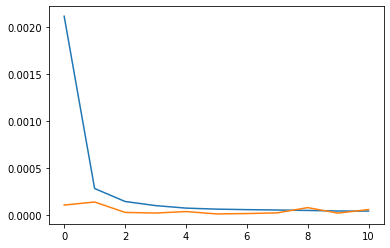

In [688]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])

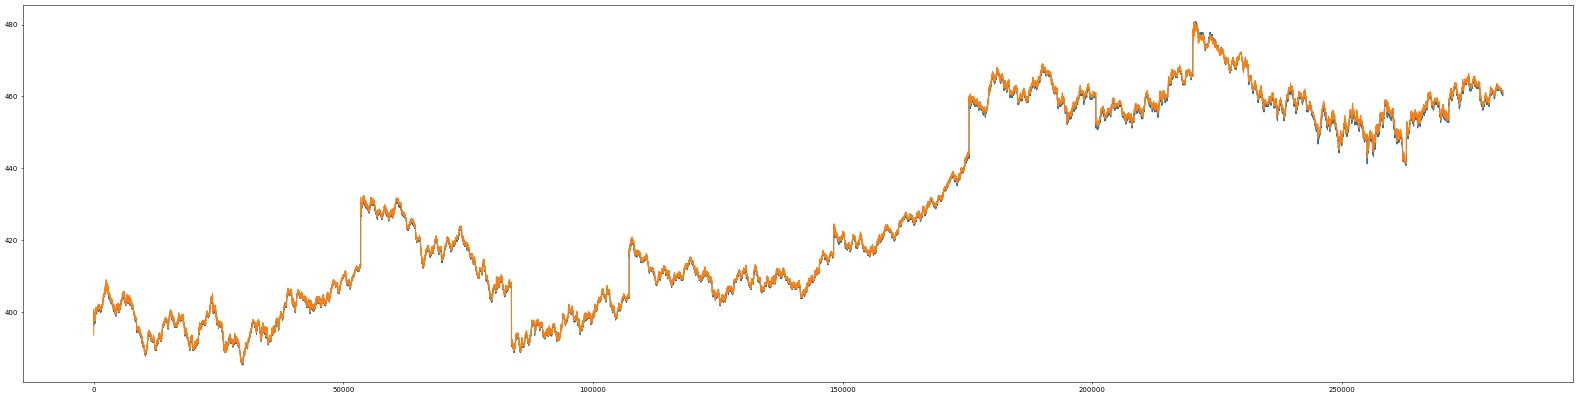

In [689]:
#train error
X_t1 = model_1.predict(X_train)
plt.figure(figsize=(40,10),dpi=50)
plt.plot(true_range(df2, Y_train, 'mid1'))
plt.plot(true_range(df2, X_t1, 'mid1'))

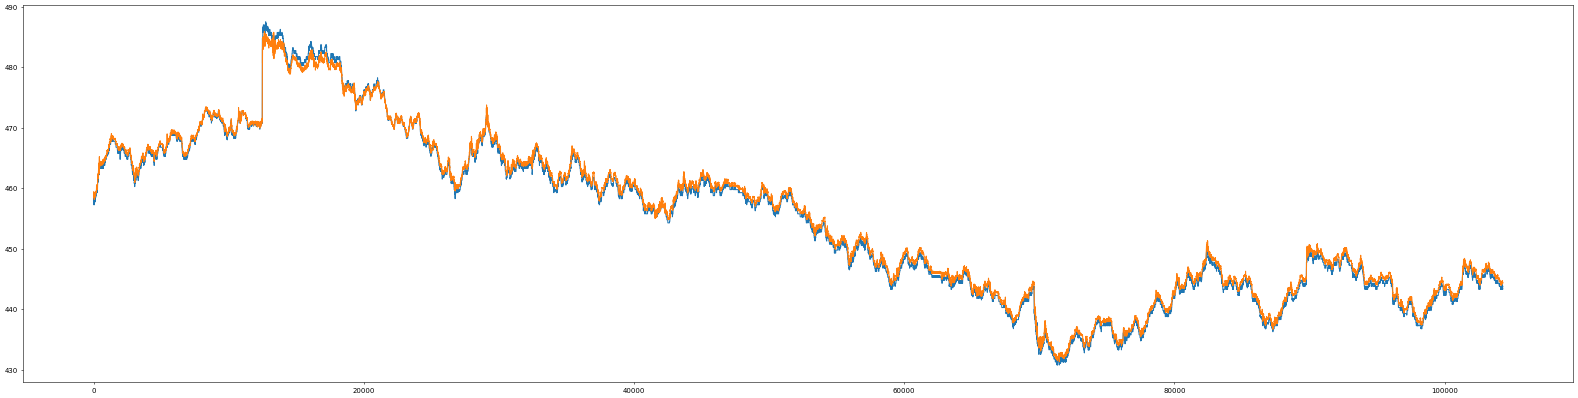

In [690]:
#test error
Xt1 = model_1.predict(X_test)
plt.figure(figsize=(40,10),dpi=50)
plt.plot(true_range(df2, Y_test, 'mid1'))
plt.plot(true_range(df2, Xt1, 'mid1'))

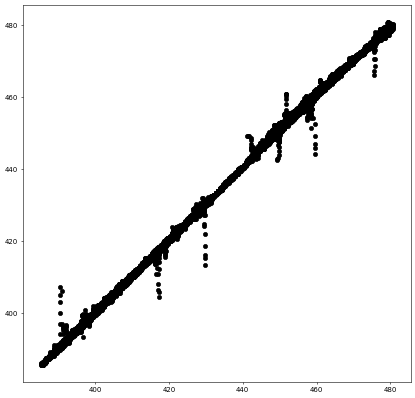

In [691]:
#train error scatter plot
plt.figure(figsize=(10,10),dpi=50)
plt.scatter(true_range(df2, Y_train, 'mid1'), true_range(df2, X_t1, 'mid1'), color = ['black'])

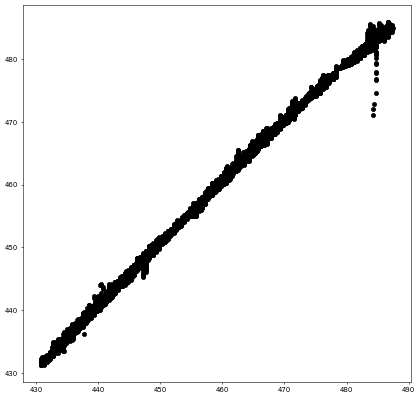

In [692]:
#test error scatter plot
plt.figure(figsize=(10,10),dpi=50)
plt.scatter(true_range(df2, Y_test, 'mid1'), true_range(df2, Xt1, 'mid1'), color = ['black'])

In [693]:
#已實現損益
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#未實現損益
df['unrealized'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df['holding'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df_test = df.iloc[282251: ]
df_train = df.iloc[0:282251]
#0~9 pred 10, hence start from 10
df_train = df_train.iloc[10:, :]
df_test = df_test.iloc[10:, :]
#calculate pred return
df_train['pred_mid'] = true_range(df2, X_t1, 'mid1')
df_train['mid_shift'] = df_train['pred_mid'].shift(1)
df_test['pred_mid'] = true_range(df2, Xt1, 'mid1')
df_test['mid_shift'] = df_test['pred_mid'].shift(1)
#pred return train
df_train['pred_return'] = (df_train['pred_mid'] / df_train['mid_shift']) - 1
#pred return test
df_test['pred_return'] = (df_test['pred_mid'] / df_test['mid_shift']) - 1

In [694]:
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_train = df_train.drop([0])
df_train = df_train.reset_index(drop = True)
df_test = df_test.drop([0])
df_test = df_test.reset_index(drop = True)

In [695]:
df_train

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1,equity_value,unrealized,holding,pred_mid,mid_shift,pred_return
0,397.0,1,2,396.5,397.0,2,6,396.0,398.0,20,...,0.0,0.0,0.0,396.75,0.0,0.0,0.0,399.780762,393.558990,0.015809
1,396.5,2,6,396.0,397.0,2,40,395.0,398.0,20,...,-31.0,-8.0,5.0,396.50,0.0,0.0,0.0,399.115387,399.780762,-0.001664
2,397.0,2,6,396.0,397.0,0,40,395.0,398.0,20,...,-31.0,-8.0,5.0,396.50,0.0,0.0,0.0,399.455383,399.115387,0.000852
3,398.0,20,6,396.0,397.0,0,40,395.0,398.0,20,...,-31.0,-8.0,5.0,396.50,0.0,0.0,0.0,399.657532,399.455383,0.000506
4,398.5,6,6,396.0,398.5,3,40,395.0,399.0,144,...,-31.0,-8.0,5.0,397.25,0.0,0.0,0.0,400.787872,399.657532,0.002828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282235,0.0,0,16,460.5,461.0,22,16,460.0,461.5,11,...,0.0,0.0,0.0,460.75,0.0,0.0,0.0,461.324219,461.425781,-0.000220
282236,0.0,0,16,460.5,461.0,21,16,460.0,461.5,11,...,0.0,0.0,0.0,460.75,0.0,0.0,0.0,461.387390,461.324219,0.000137
282237,460.5,1,15,460.5,461.0,21,16,460.0,461.5,11,...,0.0,0.0,0.0,460.75,0.0,0.0,0.0,461.415619,461.387390,0.000061
282238,461.0,1,15,460.5,461.0,20,16,460.0,461.5,11,...,0.0,0.0,0.0,460.75,0.0,0.0,0.0,461.408783,461.415619,-0.000015


In [696]:
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1,equity_value,unrealized,holding,pred_mid,mid_shift,pred_return
0,457.5,1,1,457.5,458.0,10,10,457.0,458.5,5,...,-27.0,38.0,-11.0,457.75,0.0,0.0,0.0,459.253723,459.119110,0.000293
1,0.0,0,1,457.5,458.0,12,10,457.0,458.5,5,...,0.0,0.0,0.0,457.75,0.0,0.0,0.0,459.401764,459.253723,0.000322
2,0.0,0,1,457.5,458.0,12,10,457.0,458.5,5,...,0.0,0.0,0.0,457.75,0.0,0.0,0.0,459.401031,459.401764,-0.000002
3,0.0,0,1,457.5,458.0,12,9,457.0,458.5,5,...,-27.0,38.0,-11.0,457.75,0.0,0.0,0.0,459.272766,459.401031,-0.000279
4,458.0,10,1,457.5,458.0,2,9,457.0,458.5,5,...,-27.0,38.0,-11.0,457.75,0.0,0.0,0.0,458.998199,459.272766,-0.000598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104303,443.5,2,8,443.5,444.0,8,24,443.0,444.5,23,...,-9.0,10.0,-11.0,443.75,0.0,0.0,0.0,444.412628,444.410858,0.000004
104304,443.5,1,7,443.5,444.0,8,24,443.0,444.5,23,...,-9.0,11.0,-11.0,443.75,0.0,0.0,0.0,444.419525,444.412628,0.000015
104305,0.0,0,7,443.5,444.0,8,24,443.0,444.5,23,...,0.0,0.0,0.0,443.75,0.0,0.0,0.0,444.424500,444.419525,0.000011
104306,443.5,3,4,443.5,444.0,8,24,443.0,444.5,23,...,0.0,0.0,0.0,443.75,0.0,0.0,0.0,444.453339,444.424500,0.000065


In [701]:
#using MA
#已實現損益
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#未實現損益
df['unrealized'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df['holding'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df_test_MA = df.iloc[282251: ]
df_train_MA = df.iloc[0:282251]
#0~9 pred 10, hence start from 10
df_train_MA = df_train_MA.iloc[10:, :]
df_test_MA = df_test_MA.iloc[10:, :]
#calculate MA side
df_train_MA['pred_mid'] = true_range(df2, X_t1, 'mid1')
df_train_MA['MA'] = MA(df_train_MA['pred_mid'], 10).shift(1)
df_test_MA['pred_mid'] = true_range(df2, Xt1, 'mid1')
df_test_MA['MA'] = MA(df_test_MA['pred_mid'], 10).shift(1)
#MA side
df_train_MA['MA_side'] = df_train_MA['pred_mid'] / df_train_MA['MA'] -1
df_test_MA['MA_side'] = df_test_MA['pred_mid'] / df_test_MA['MA'] -1
#drop nan
df_train_MA = df_train_MA.dropna()
df_train_MA = df_train_MA.reset_index(drop = True)
df_test_MA = df_test_MA.dropna()
df_test_MA = df_test_MA.reset_index(drop = True)

In [702]:
df_train_MA

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1,equity_value,unrealized,holding,pred_mid,MA,MA_side
0,398.0,1,6,396.0,398.5,2,40,395.0,399.0,144,...,-31.0,-8.0,5.0,397.25,0.0,0.0,0.0,398.489136,398.059927,0.001078
1,398.5,1,6,396.0,398.5,1,40,395.0,399.0,144,...,-31.0,-8.0,5.0,397.25,0.0,0.0,0.0,398.200104,398.552942,-0.000885
2,0.0,0,20,396.0,398.5,1,40,395.0,399.0,144,...,0.0,0.0,0.0,397.25,0.0,0.0,0.0,397.964203,398.394876,-0.001081
3,0.0,0,20,396.0,398.5,1,40,395.0,399.0,144,...,0.0,0.0,0.0,397.25,0.0,0.0,0.0,397.701294,398.279758,-0.001452
4,0.0,0,20,396.0,398.0,1,40,395.0,398.5,1,...,0.0,0.0,0.0,397.00,0.0,0.0,0.0,397.676697,398.104349,-0.001074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282226,0.0,0,16,460.5,461.0,22,16,460.0,461.5,11,...,0.0,0.0,0.0,460.75,0.0,0.0,0.0,461.324219,461.318427,0.000013
282227,0.0,0,16,460.5,461.0,21,16,460.0,461.5,11,...,0.0,0.0,0.0,460.75,0.0,0.0,0.0,461.387390,461.335544,0.000112
282228,460.5,1,15,460.5,461.0,21,16,460.0,461.5,11,...,0.0,0.0,0.0,460.75,0.0,0.0,0.0,461.415619,461.356308,0.000129
282229,461.0,1,15,460.5,461.0,20,16,460.0,461.5,11,...,0.0,0.0,0.0,460.75,0.0,0.0,0.0,461.408783,461.366208,0.000092


In [703]:
df_test_MA

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1,equity_value,unrealized,holding,pred_mid,MA,MA_side
0,458.0,2,10,457.0,458.5,5,14,456.5,459.0,10,...,27.0,-38.0,11.0,457.75,0.0,0.0,0.0,458.489563,459.195993,-0.001538
1,0.0,0,11,457.0,458.5,5,14,456.5,459.0,10,...,27.0,-38.0,11.0,457.75,0.0,0.0,0.0,458.576538,459.133038,-0.001212
2,0.0,0,1,458.0,458.5,5,11,457.0,459.0,10,...,0.0,0.0,0.0,458.25,0.0,0.0,0.0,458.607147,459.065320,-0.000998
3,458.0,1,11,457.0,458.5,5,14,456.5,459.0,10,...,27.0,-38.0,11.0,457.75,0.0,0.0,0.0,458.742889,458.985858,-0.000529
4,0.0,0,11,457.0,457.5,1,14,456.5,458.5,5,...,27.0,-38.0,11.0,457.25,0.0,0.0,0.0,458.661926,458.920044,-0.000562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104294,443.5,2,8,443.5,444.0,8,24,443.0,444.5,23,...,-9.0,10.0,-11.0,443.75,0.0,0.0,0.0,444.412628,444.305936,0.000240
104295,443.5,1,7,443.5,444.0,8,24,443.0,444.5,23,...,-9.0,11.0,-11.0,443.75,0.0,0.0,0.0,444.419525,444.329340,0.000203
104296,0.0,0,7,443.5,444.0,8,24,443.0,444.5,23,...,0.0,0.0,0.0,443.75,0.0,0.0,0.0,444.424500,444.346219,0.000176
104297,443.5,3,4,443.5,444.0,8,24,443.0,444.5,23,...,0.0,0.0,0.0,443.75,0.0,0.0,0.0,444.453339,444.364877,0.000199


In [706]:
df_train_MA.to_csv('./data/df_train_MA.csv')
df_test_MA.to_csv('./data/df_test_MA.csv')

# mid1_train

In [722]:
#setting parameters
import itertools 
long_side, short_side, stop_1 = [0.003, 0.0025, 0.002, 0.0015, 0.001], [-0.003, -0.0025, -0.002, -0.0015, -0.001], [-0.01, -0.015, -0.02, -0.025]
paras = list(itertools.product(long_side, short_side, stop_1))
paras

[(0.003, -0.003, -0.01),
 (0.003, -0.003, -0.015),
 (0.003, -0.003, -0.02),
 (0.003, -0.003, -0.025),
 (0.003, -0.0025, -0.01),
 (0.003, -0.0025, -0.015),
 (0.003, -0.0025, -0.02),
 (0.003, -0.0025, -0.025),
 (0.003, -0.002, -0.01),
 (0.003, -0.002, -0.015),
 (0.003, -0.002, -0.02),
 (0.003, -0.002, -0.025),
 (0.003, -0.0015, -0.01),
 (0.003, -0.0015, -0.015),
 (0.003, -0.0015, -0.02),
 (0.003, -0.0015, -0.025),
 (0.003, -0.001, -0.01),
 (0.003, -0.001, -0.015),
 (0.003, -0.001, -0.02),
 (0.003, -0.001, -0.025),
 (0.0025, -0.003, -0.01),
 (0.0025, -0.003, -0.015),
 (0.0025, -0.003, -0.02),
 (0.0025, -0.003, -0.025),
 (0.0025, -0.0025, -0.01),
 (0.0025, -0.0025, -0.015),
 (0.0025, -0.0025, -0.02),
 (0.0025, -0.0025, -0.025),
 (0.0025, -0.002, -0.01),
 (0.0025, -0.002, -0.015),
 (0.0025, -0.002, -0.02),
 (0.0025, -0.002, -0.025),
 (0.0025, -0.0015, -0.01),
 (0.0025, -0.0015, -0.015),
 (0.0025, -0.0015, -0.02),
 (0.0025, -0.0015, -0.025),
 (0.0025, -0.001, -0.01),
 (0.0025, -0.001, -0.015

In [746]:
(df_train['pred_return'] > 0.003).sum()

37

In [747]:
(df_train['pred_return'] < -0.003).sum()

19

In [748]:
paras = [(0.003, -0.003, -0.015)]

In [723]:
#side + hard stop(-~%)

In [749]:
#adding hard stop 
#main strategy (train set)
#record transaction
transaction_history1 = {}
#record equity values
equity_value_1 = pd.DataFrame()
#record each returns
each_return1 = pd.DataFrame()
#record unrealized gain
unrealized_1 = pd.DataFrame()
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['pred_return'].iloc[j] > paras[l][0]:
            #反過來做 -> 漲 -> -1
            df_train['side'].iloc[j] = 1
        elif df_train['pred_return'].iloc[j] < paras[l][1]:
            #反過來做-> 跌-> 1
            df_train['side'].iloc[j] = -1
    date_idx = df_train['TxTime'].unique()
    #紀錄已實現
    equity_value1 = pd.DataFrame()
    #紀錄未實現
    unrealized1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]):# or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
        unrealized1 = pd.concat([unrealized1, df['unrealized']])
    #concat
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

In [750]:
equity_value_1

,equity_value
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
282235,-0.120326
282236,-0.120326
282237,-0.120326
282238,-0.120326


In [751]:
transaction_history1[(0.003, -0.003, -0.015)]

[{'Date': '2020-03-25',
  'tick': 0,
  'Action': 1,
  'Price': 397.0,
  'Equity_value': 0},
 {'Date': '2020-03-25',
  'tick': 5,
  'Action': -1,
  'Price': 396.0,
  'Equity_value': -0.004018891687657398},
 {'Date': '2020-03-25',
  'tick': 5,
  'Action': -1,
  'Price': 396.0,
  'Equity_value': -0.0015},
 {'Date': '2020-03-25',
  'tick': 9,
  'Action': 1,
  'Price': 398.5,
  'Equity_value': -0.0063131313131312705},
 {'Date': '2020-03-25',
  'tick': 9,
  'Action': 1,
  'Price': 398.5,
  'Equity_value': 0},
 {'Date': '2020-03-25',
  'tick': 9579,
  'Action': -1,
  'Price': 392.0,
  'Equity_value': -0.017811166875784157},
 {'Date': '2020-03-27',
  'tick': 1,
  'Action': 1,
  'Price': 430.0,
  'Equity_value': 0},
 {'Date': '2020-03-27',
  'tick': 10,
  'Action': -1,
  'Price': 429.0,
  'Equity_value': -0.0038255813953488858},
 {'Date': '2020-03-27',
  'tick': 10,
  'Action': -1,
  'Price': 429.0,
  'Equity_value': -0.0015},
 {'Date': '2020-03-27',
  'tick': 11,
  'Action': 1,
  'Price': 430.

In [726]:
equity_value_1.columns = paras
equity_value_1

,"(0.003, -0.003, -0.01)","(0.003, -0.003, -0.015)","(0.003, -0.003, -0.02)","(0.003, -0.003, -0.025)","(0.003, -0.0025, -0.01)","(0.003, -0.0025, -0.015)","(0.003, -0.0025, -0.02)","(0.003, -0.0025, -0.025)","(0.003, -0.002, -0.01)","(0.003, -0.002, -0.015)",...,"(0.001, -0.002, -0.02)","(0.001, -0.002, -0.025)","(0.001, -0.0015, -0.01)","(0.001, -0.0015, -0.015)","(0.001, -0.0015, -0.02)","(0.001, -0.0015, -0.025)","(0.001, -0.001, -0.01)","(0.001, -0.001, -0.015)","(0.001, -0.001, -0.02)","(0.001, -0.001, -0.025)"
0,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,...,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500
1,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,...,-0.001500,-0.001500,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761
2,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,...,-0.001500,-0.001500,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761
3,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,...,-0.001500,-0.001500,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761,-0.002761
4,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,...,-0.001500,-0.001500,-0.008280,-0.008280,-0.008280,-0.008280,-0.008280,-0.008280,-0.008280,-0.008280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282235,-0.068328,0.027558,0.009062,0.027694,-0.149125,0.003118,-0.016621,0.042286,-0.187139,-0.098227,...,-0.328369,-0.295260,-0.557809,-0.503017,-0.525589,-0.497520,-1.116598,-1.053251,-1.081375,-1.032211
282236,-0.068328,0.027558,0.009062,0.027694,-0.149125,0.003118,-0.016621,0.042286,-0.187139,-0.098227,...,-0.328369,-0.295260,-0.557809,-0.503017,-0.525589,-0.497520,-1.116598,-1.053251,-1.081375,-1.032211
282237,-0.068328,0.027558,0.009062,0.027694,-0.149125,0.003118,-0.016621,0.042286,-0.187139,-0.098227,...,-0.328369,-0.295260,-0.557809,-0.503017,-0.525589,-0.497520,-1.116598,-1.053251,-1.081375,-1.032211
282238,-0.068328,0.027558,0.009062,0.027694,-0.149125,0.003118,-0.016621,0.042286,-0.187139,-0.098227,...,-0.328369,-0.295260,-0.557809,-0.503017,-0.525589,-0.497520,-1.116598,-1.053251,-1.081375,-1.032211


In [730]:
equity_value_1.iloc[-1].sort_values().tail(10)

(0.0025, -0.003, -0.025)    -0.007021
(0.002, -0.003, -0.025)     -0.005919
(0.003, -0.002, -0.025)     -0.001085
(0.003, -0.0025, -0.015)     0.003118
(0.0025, -0.0025, -0.025)    0.007572
(0.002, -0.0025, -0.025)     0.008675
(0.003, -0.003, -0.02)       0.009062
(0.003, -0.003, -0.015)      0.027558
(0.003, -0.003, -0.025)      0.027694
(0.003, -0.0025, -0.025)     0.042286
Name: 282239, dtype: float64

In [729]:
performance(equity_value_1[[(0.003, -0.003, -0.025)]], transaction_history1[(0.003, -0.003, -0.025)])

return: 0.027693864366203094
std: 0.026433732848054062
sharp ratio: 0.850953003705604
trades: 21.0
odds ratio: 0.23809523809523808
mdd: 0.048822539177532924
skewness: 0.6024898657462869


(0.027693864366203094,
 0.026433732848054062,
 0.850953003705604,
 21.0,
 0.23809523809523808,
 0.048822539177532924,
 0.6024898657462869)

In [731]:
transaction_history1[(0.003, -0.003, -0.025)]

[{'Date': '2020-03-25',
  'tick': 0,
  'Action': -1,
  'Price': 396.5,
  'Equity_value': -0.0015},
 {'Date': '2020-03-25',
  'tick': 5,
  'Action': 1,
  'Price': 398.5,
  'Equity_value': -0.0050441361916770955},
 {'Date': '2020-03-25',
  'tick': 5,
  'Action': 1,
  'Price': 398.5,
  'Equity_value': 0},
 {'Date': '2020-03-25',
  'tick': 9,
  'Action': -1,
  'Price': 396.0,
  'Equity_value': -0.0077735257214554526},
 {'Date': '2020-03-25',
  'tick': 9,
  'Action': -1,
  'Price': 396.0,
  'Equity_value': -0.0015},
 {'Date': '2020-03-25',
  'tick': 2318,
  'Action': 1,
  'Price': 406.5,
  'Equity_value': -0.026515151515151603},
 {'Date': '2020-03-27',
  'tick': 1,
  'Action': -1,
  'Price': 429.5,
  'Equity_value': -0.0015},
 {'Date': '2020-03-27',
  'tick': 10,
  'Action': 1,
  'Price': 430.0,
  'Equity_value': -0.0011641443538998875},
 {'Date': '2020-03-27',
  'tick': 10,
  'Action': 1,
  'Price': 430.0,
  'Equity_value': 0},
 {'Date': '2020-03-27',
  'tick': 11,
  'Action': -1,
  'Price

In [628]:
equity_value_1.columns = paras
equity_value_1

,"(0.003, -0.003, 0.02, -0.01)","(0.003, -0.0025, 0.02, -0.01)","(0.003, -0.002, 0.02, -0.01)","(0.003, -0.0015, 0.02, -0.01)","(0.003, -0.001, 0.02, -0.01)","(0.0025, -0.003, 0.02, -0.01)","(0.0025, -0.0025, 0.02, -0.01)","(0.0025, -0.002, 0.02, -0.01)","(0.0025, -0.0015, 0.02, -0.01)","(0.0025, -0.001, 0.02, -0.01)",...,"(0.0015, -0.003, 0.02, -0.01)","(0.0015, -0.0025, 0.02, -0.01)","(0.0015, -0.002, 0.02, -0.01)","(0.0015, -0.0015, 0.02, -0.01)","(0.0015, -0.001, 0.02, -0.01)","(0.001, -0.003, 0.02, -0.01)","(0.001, -0.0025, 0.02, -0.01)","(0.001, -0.002, 0.02, -0.01)","(0.001, -0.0015, 0.02, -0.01)","(0.001, -0.001, 0.02, -0.01)"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282234,0.080385,0.080385,0.067828,0.067828,0.060630,0.057403,0.057403,0.044846,0.044846,0.046113,...,0.065707,0.065707,0.065707,0.065707,0.066960,0.029000,0.029000,0.028999,0.028999,0.087760
282235,0.080385,0.080385,0.067828,0.067828,0.060630,0.057403,0.057403,0.044846,0.044846,0.046113,...,0.065707,0.065707,0.065707,0.065707,0.066960,0.029000,0.029000,0.028999,0.028999,0.087760
282236,0.080385,0.080385,0.067828,0.067828,0.060630,0.057403,0.057403,0.044846,0.044846,0.046113,...,0.065707,0.065707,0.065707,0.065707,0.066960,0.029000,0.029000,0.028999,0.028999,0.087760
282237,0.080385,0.080385,0.067828,0.067828,0.060630,0.057403,0.057403,0.044846,0.044846,0.046113,...,0.065707,0.065707,0.065707,0.065707,0.066960,0.029000,0.029000,0.028999,0.028999,0.087760


In [642]:
equity_value_1.iloc[-1].sort_values(ascending=False).index.to_list()

[(0.001, -0.001, 0.02, -0.01),
 (0.003, -0.0025, 0.02, -0.01),
 (0.003, -0.003, 0.02, -0.01),
 (0.003, -0.002, 0.02, -0.01),
 (0.003, -0.0015, 0.02, -0.01),
 (0.0015, -0.001, 0.02, -0.01),
 (0.0015, -0.0025, 0.02, -0.01),
 (0.0015, -0.003, 0.02, -0.01),
 (0.0015, -0.0015, 0.02, -0.01),
 (0.0015, -0.002, 0.02, -0.01),
 (0.003, -0.001, 0.02, -0.01),
 (0.0025, -0.003, 0.02, -0.01),
 (0.0025, -0.0025, 0.02, -0.01),
 (0.002, -0.003, 0.02, -0.01),
 (0.002, -0.0025, 0.02, -0.01),
 (0.0025, -0.001, 0.02, -0.01),
 (0.002, -0.001, 0.02, -0.01),
 (0.0025, -0.0015, 0.02, -0.01),
 (0.0025, -0.002, 0.02, -0.01),
 (0.002, -0.002, 0.02, -0.01),
 (0.002, -0.0015, 0.02, -0.01),
 (0.001, -0.003, 0.02, -0.01),
 (0.001, -0.0025, 0.02, -0.01),
 (0.001, -0.0015, 0.02, -0.01),
 (0.001, -0.002, 0.02, -0.01)]

In [643]:
for i in equity_value_1.iloc[-1].sort_values(ascending=False).index.to_list():
    print(i)
    performance(equity_value_1[[i]], transaction_history1[i])

(0.001, -0.001, 0.02, -0.01)
return: 0.07900728479703834
std: 0.026101921350556473
sharp ratio: 2.8276571600145757
trades: 20.0
odds ratio: 0.7
mdd: 0.03291086440570601
skewness: -0.1277909231586134
(0.003, -0.0025, 0.02, -0.01)
return: 0.07163210735104575
std: 0.025907832760906968
sharp ratio: 2.564170765039327
trades: 10.0
odds ratio: 0.8
mdd: 0.03291086440570601
skewness: 0.17267997855775394
(0.003, -0.003, 0.02, -0.01)
return: 0.07163210735104575
std: 0.025907832760906968
sharp ratio: 2.564170765039327
trades: 10.0
odds ratio: 0.8
mdd: 0.03291086440570601
skewness: 0.17267997855775394
(0.003, -0.002, 0.02, -0.01)
return: 0.05907522653358194
std: 0.025482910372872366
sharp ratio: 2.1141708598141284
trades: 11.0
odds ratio: 0.7272727272727273
mdd: 0.03291086440570601
skewness: 0.21761139807253838
(0.003, -0.0015, 0.02, -0.01)
return: 0.05907522653358194
std: 0.025482910372872366
sharp ratio: 2.1141708598141284
trades: 11.0
odds ratio: 0.7272727272727273
mdd: 0.03291086440570601
skewn

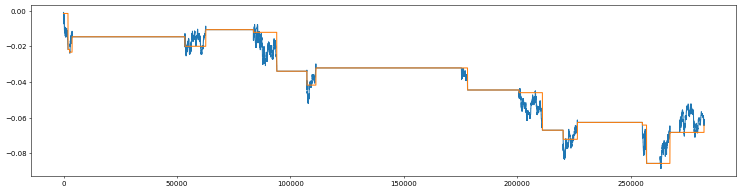

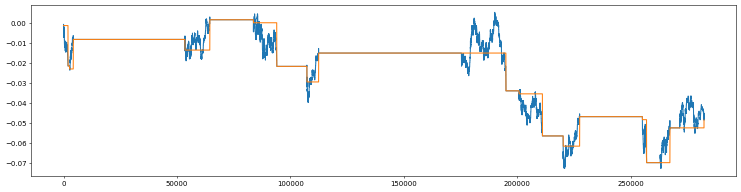

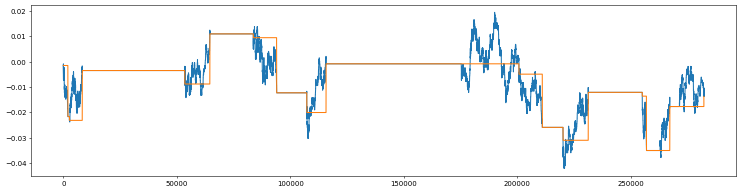

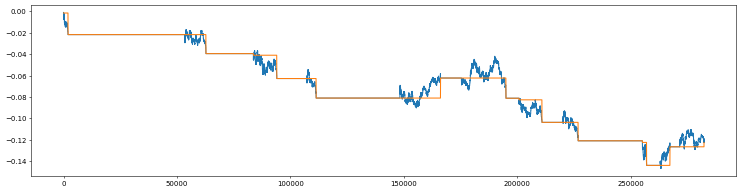

In [475]:
for k in range(len(paras)):
    r_idx = (each_return1.iloc[:, k][each_return1.iloc[:, k] != 0]).index.tolist()
    #將realized gain補進去
    for i in r_idx:
        unrealized_1.iloc[i, k] = equity_value_1['equity_value'].iloc[i, k]
    r_idx.insert(0,0)
    unrealized_df = pd.DataFrame()
    for j in range(len(r_idx) - 1):
        unrealized_df = pd.concat([unrealized_df, np.cumsum(unrealized_1.iloc[r_idx[j]:r_idx[j+1], k])], axis = 0)
    unrealized_df = pd.concat([unrealized_df, equity_value_1['equity_value'].iloc[r_idx[-1]:, k]], axis = 0)
    unrealized_df = unrealized_df.reset_index(drop = True)
    plt.figure(figsize=(40,10),dpi=50)
    plt.subplot(2, 2, k+1)
    plt.plot(unrealized_df)
    plt.plot(equity_value_1.iloc[:, k])

In [464]:
tick_0325 = []
idx_0325 = []
for i in range(len(transaction_history1[(0.003, -0.002, 0.02, -0.02)])):
    if transaction_history1[(0.003, -0.002, 0.02, -0.02)][i]['Date'] == '2020-03-25':
        tick_0325.append(transaction_history1[(0.003, -0.002, 0.02, -0.02)][i]['tick'])
        idx_0325.append(i)

In [465]:
side_0325 = []
for i in idx_0325:
    if transaction_history1[(0.003, -0.002, 0.02, -0.02)][i]['Date'] == '2020-03-25':
        side_0325.append(transaction_history1[(0.003, -0.002, 0.02, -0.02)][i]['Action'])

In [466]:
tick_long_0325 = []
tick_short_0325 = []
for i in range(len(idx_0325)):
    if side_0325[i] == 1:
        tick_long_0325.append(tick_0325[i])
    else:
        tick_short_0325.append(tick_0325[i])

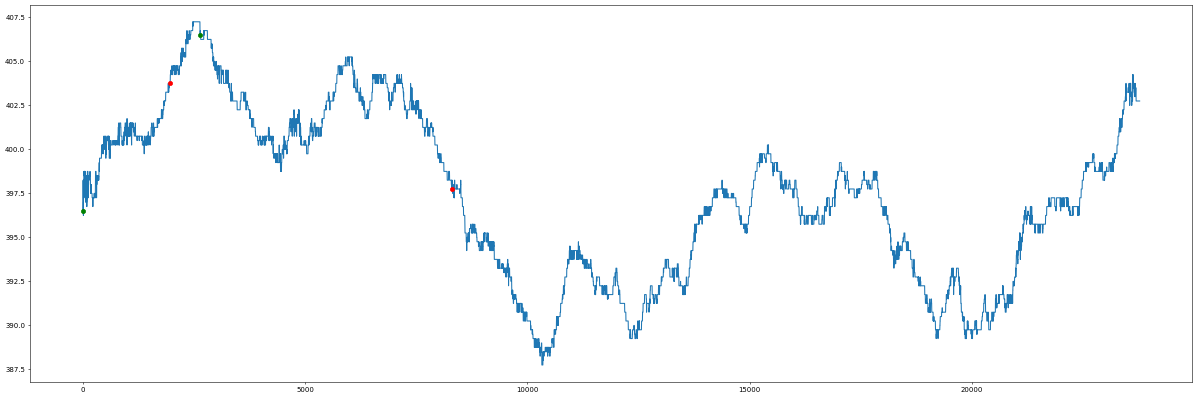

In [467]:
plt.figure(figsize=(30,10),dpi=50)
plt.plot(df_train[df_train.TxTime == '2020-03-25']['mid1'])
plt.plot(tick_long_0325, df_train[df_train.TxTime == '2020-03-25'][['mid1']].loc[tick_long_0325] ,'ro')
plt.plot(tick_short_0325, df_train[df_train.TxTime == '2020-03-25'][['mid1']].loc[tick_short_0325] ,'go')

In [468]:
tick_long_0325

[1967, 8301]

In [469]:
tick_short_0325

[0, 2646]

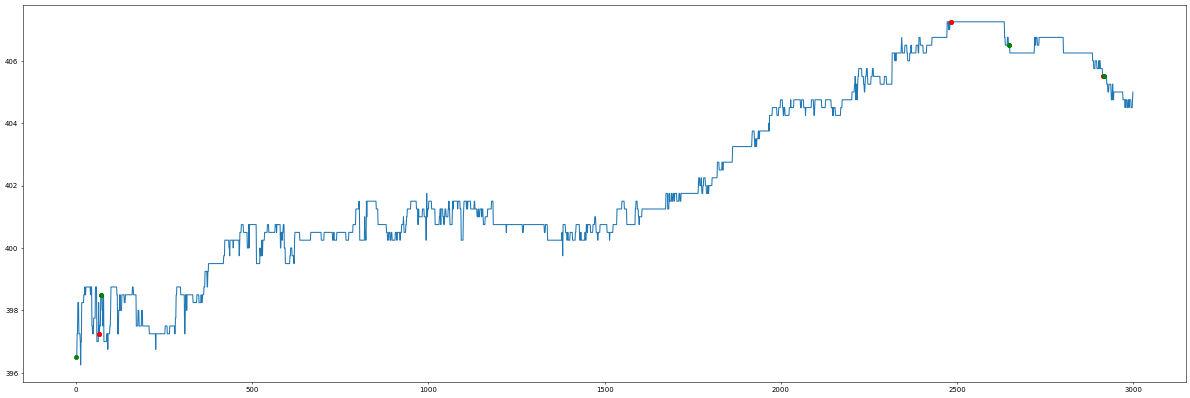

In [455]:
plt.figure(figsize=(30,10),dpi=50)
plt.plot(df_train[df_train.TxTime == '2020-03-25']['mid1'].iloc[:3000])
plt.plot([66, 66, 2483, 2483, 2913, 2913], df_train[df_train.TxTime == '2020-03-25'][['mid1']].loc[[66, 66, 2483, 2483, 2913, 2913]] ,'ro')
plt.plot(tick_short_0325, df_train[df_train.TxTime == '2020-03-25'][['mid1']].loc[tick_short_0325] ,'go')

# mid1_test 

In [714]:
#test set
paras = [(0.003, -0.0025, 0.02, -0.01)]

In [719]:
#adding hard stop 
#main strategy (train set)
#record transaction
transaction_history2 = {}
#record equity values
equity_value_2 = pd.DataFrame()
#record each returns
each_return2 = pd.DataFrame()
#record unrealized gain
unrealized_2 = pd.DataFrame()
for l in range(len(paras)):
    df_test['side'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
    for j in range(len(df_test)):
        if df_test['pred_return'].iloc[j] > paras[l][0]:
            #反過來做 -> 漲 -> -1
            df_test['side'].iloc[j] = -1
        elif df_test['pred_return'].iloc[j] < paras[l][1]:
            #反過來做-> 跌-> 1
            df_test['side'].iloc[j] = 1
    date_idx = df_test['TxTime'].unique()
    #紀錄已實現
    equity_value2 = pd.DataFrame()
    #紀錄未實現
    unrealized2 = pd.DataFrame()
    for k in date_idx:
        df = df_test[df_test.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history2[paras[l]][-1]['Price'] - 1) < paras[l][3]): #or ((df['mid1'].iloc[i-1] / transaction_history2[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): 
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history2)
                        transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][3]): #or ((df['mid1'].iloc[i-1] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                        transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value2 = pd.concat([equity_value2, df[['equity_value']]])
        unrealized2 = pd.concat([unrealized2, df['unrealized']])
    #concat
    equity_value_2 = pd.concat([equity_value_2, np.cumsum(equity_value2)], axis = 1)
    each_return2 = pd.concat([each_return2, equity_value2], axis = 1)
    unrealized_2 = pd.concat([unrealized_2, unrealized2], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

In [720]:
#side + hard stop (-1%)
equity_value_2

,equity_value
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
104303,0.035749
104304,0.035749
104305,0.035749
104306,0.035749


In [721]:
performance(equity_value_2[['equity_value']], transaction_history2[paras[0]])

return: 0.03574874192759042
std: 0.018505588821488086
sharp ratio: 1.6507846479393413
trades: 3.0
odds ratio: 0.3333333333333333
mdd: 0.006562919579117529
skewness: -0.8449961482676159


(0.03574874192759042,
 0.018505588821488086,
 1.6507846479393413,
 3.0,
 0.3333333333333333,
 0.006562919579117529,
 -0.8449961482676159)

In [717]:
#side + hard stop (+2, -1)
performance(equity_value_2[['equity_value']], transaction_history2[paras[0]])

return: 0.013044923558137415
std: 0.006128019614646174
sharp ratio: 1.2801727232379907
trades: 3.0
odds ratio: 0.3333333333333333
mdd: 0.006562919579117529
skewness: -1.8146715586484685


(0.013044923558137415,
 0.006128019614646174,
 1.2801727232379907,
 3.0,
 0.3333333333333333,
 0.006562919579117529,
 -1.8146715586484685)

In [650]:
equity_value_2.columns = paras
equity_value_2

,"(0.001, -0.001, 0.02, -0.01)","(0.003, -0.0025, 0.02, -0.01)","(0.003, -0.003, 0.02, -0.01)"
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
...,...,...,...
104302,-0.064211,0.007798,0.007798
104303,-0.064211,0.007798,0.007798
104304,-0.064211,0.007798,0.007798
104305,-0.064211,0.007798,0.007798


In [651]:
for i in equity_value_2.iloc[-1].sort_values(ascending=False).index.to_list():
    print(i)
    performance(equity_value_2[[i]], transaction_history2[i])

(0.003, -0.003, 0.02, -0.01)
return: 0.0077975206611570775
std: 0.003165893741648257
sharp ratio: 0.8204699440748546
trades: 1.0
odds ratio: 1.0
mdd: 0.0015
skewness: -1.7369376881292617
(0.003, -0.0025, 0.02, -0.01)
return: 0.0077975206611570775
std: 0.003165893741648257
sharp ratio: 0.8204699440748546
trades: 1.0
odds ratio: 1.0
mdd: 0.0015
skewness: -1.7369376881292617
(0.001, -0.001, 0.02, -0.01)
return: -0.06421101613078178
std: 0.029503834405700754
sharp ratio: -2.352610009137325
trades: 11.0
odds ratio: 0.18181818181818182
mdd: 0.09110902307627478
skewness: -0.2348506944796161


In [495]:
#adding hard stop 
#main strategy (test set)
#record transaction
transaction_history2 = {}
#record equity values
equity_value_2 = pd.DataFrame()
#record each returns
each_return2 = pd.DataFrame()
#record unrealized gain
unrealized_2 = pd.DataFrame()
for l in range(len(paras)):
    df_test['side'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
    for j in range(len(df_test)):
        if df_test['pred_return'].iloc[j] > paras[l][0]:
            df_test['side'].iloc[j] = 1
        elif df_test['pred_return'].iloc[j] < paras[l][1]:
            df_test['side'].iloc[j] = -1
    date_idx = df_test['TxTime'].unique()
    #紀錄已實現
    equity_value2 = pd.DataFrame()
    #紀錄未實現
    unrealized2 = pd.DataFrame()
    for k in date_idx:
        df = df_test[df_test.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history2[paras[l]][-1]['Price'] - 1) < paras[l][3]) or ((df['mid1'].iloc[i-1] / transaction_history2[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history2)
                        transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and (((df['mid1'].iloc[i-1] / transaction_history2[paras[l]][-1]['Price'] - 1) < paras[l][3]) or ((df['mid1'].iloc[i-1] / transaction_history2[paras[l]][-1]['Price'] - 1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                        transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history2 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history2 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value2 = pd.concat([equity_value2, df[['equity_value']]])
        unrealized2 = pd.concat([unrealized2, df['unrealized']])
    #concat
    equity_value_2 = pd.concat([equity_value_2, np.cumsum(equity_value2)], axis = 1)
    each_return2 = pd.concat([each_return2, equity_value2], axis = 1)
    unrealized_2 = pd.concat([unrealized_2, unrealized2], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

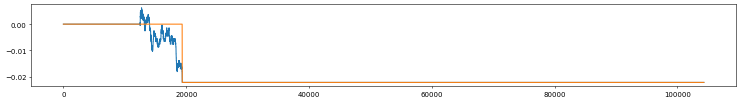

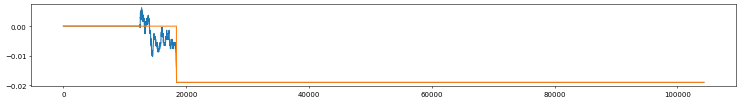

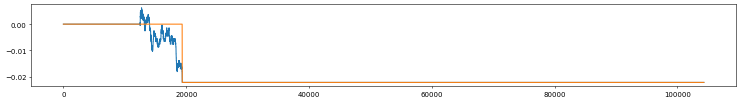

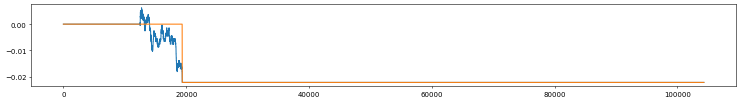

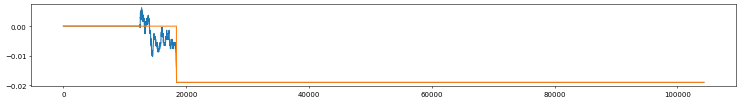

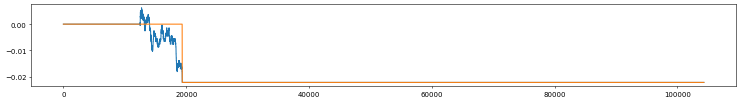

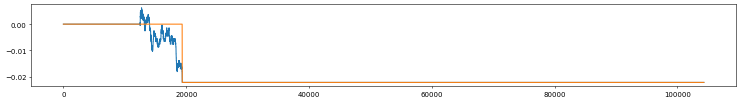

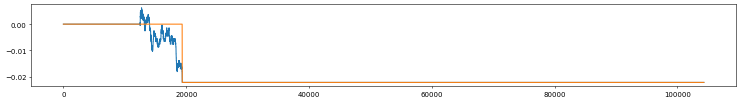

In [496]:
for k in range(len(paras)):
    r_idx = (each_return2.iloc[:, k][each_return2.iloc[:, k] != 0]).index.tolist()
    #將realized gain補進去
    for i in r_idx:
        unrealized_2.iloc[i, k] = equity_value_2['equity_value'].iloc[i, k]
    r_idx.insert(0,0)
    unrealized_df = pd.DataFrame()
    for j in range(len(r_idx) - 1):
        unrealized_df = pd.concat([unrealized_df, np.cumsum(unrealized_2.iloc[r_idx[j]:r_idx[j+1], k])], axis = 0)
    unrealized_df = pd.concat([unrealized_df, equity_value_2['equity_value'].iloc[r_idx[-1]:, k]], axis = 0)
    unrealized_df = unrealized_df.reset_index(drop = True)
    plt.figure(figsize=(40,10),dpi=50)
    plt.subplot(4, 2, k+1)
    plt.plot(unrealized_df)
    plt.plot(equity_value_2.iloc[:, k])

In [497]:
equity_value_2.columns = paras
equity_value_2

,"(0.003, -0.002, 0.015, -0.02)","(0.0025, -0.002, 0.015, -0.015)","(0.0025, -0.002, 0.015, -0.02)","(0.0025, -0.002, 0.02, -0.02)","(0.002, -0.002, 0.015, -0.015)","(0.002, -0.002, 0.015, -0.02)","(0.002, -0.002, 0.02, -0.02)","(0.0015, -0.002, 0.015, -0.02)"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
104302,-0.022119,-0.019026,-0.022119,-0.022119,-0.019026,-0.022119,-0.022119,-0.022119
104303,-0.022119,-0.019026,-0.022119,-0.022119,-0.019026,-0.022119,-0.022119,-0.022119
104304,-0.022119,-0.019026,-0.022119,-0.022119,-0.019026,-0.022119,-0.022119,-0.022119
104305,-0.022119,-0.019026,-0.022119,-0.022119,-0.019026,-0.022119,-0.022119,-0.022119


In [499]:
transaction_history2[(0.0025, -0.002, 0.015, -0.015)]

[{'Date': '2020-04-17',
  'tick': 2,
  'Action': 1,
  'Price': 485.0,
  'Equity_value': 0},
 {'Date': '2020-04-17',
  'tick': 5934,
  'Action': -1,
  'Price': 476.5,
  'Equity_value': -0.01902577319587634}]

In [506]:
(df_test['pred_return'] > 0.0005).sum()

219

In [504]:
df_test['pred_return'].describe()

count    1.043070e+05
mean    -2.876037e-07
std      1.220872e-04
min     -1.551092e-03
25%     -4.315376e-05
50%      1.192093e-07
75%      4.196167e-05
max      6.993175e-03
Name: pred_return, dtype: float64

# using MA

In [551]:
#已實現損益
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#未實現損益
df['unrealized'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df['holding'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df_test = df.iloc[282251: ]
df_train = df.iloc[0:282251]
#1~10 pred 11, hence start from 11
df_train = df_train.iloc[11:, :]
df_test = df_test.iloc[11:, :]
#calculate MA side
df_train['pred_mid'] = true_range(df2, X_t1, 'mid1')
df_train['MA'] = MA(df_train['pred_mid'], 10).shift(1)
df_test['pred_mid'] = true_range(df2, Xt1, 'mid1')
df_test['MA'] = MA(df_test['pred_mid'], 10).shift(1)
#MA side
df_train['MA_side'] = df_train['pred_mid'] / df_train['MA'] -1
df_test['MA_side'] = df_test['pred_mid'] / df_test['MA'] -1

In [553]:
#drop nan
df_train = df_train.dropna()
df_train = df_train.reset_index(drop = True)
df_test = df_test.dropna()
df_test = df_test.reset_index(drop = True)

In [556]:
df_train.TxTime.unique()

array(['2020-03-25', '2020-03-26', '2020-03-27', '2020-03-30',
       '2020-03-31', '2020-04-01', '2020-04-06', '2020-04-07',
       '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-13',
       '2020-04-14', '2020-04-15'], dtype=object)

In [557]:
df_test.TxTime.unique()

array(['2020-04-16', '2020-04-17', '2020-04-20', '2020-04-21',
       '2020-04-22', '2020-04-23'], dtype=object)

In [583]:
(df_train['MA_side'] > 0.0015).sum()

269

In [592]:
(df_test['MA_side'] < -0.0015).sum()

60

In [ ]:
#setting parameters
import itertools 
long_side, short_side, stop_1, stop_2 = [0.002, 0.0017, 0.0015, 0.0013, 0.001], [-0.002, -0.0017, -0.0015, -0.0013, -0.001], [0.015, 0.02], [-0.015, -0.02]
paras = list(itertools.product(long_side, short_side, stop_1, stop_2))

In [595]:
paras = [(0.0015, -0.0015, 0.02, -0.01)]

In [599]:
#adding hard stop 
#main strategy (train set)
#record transaction
transaction_history1 = {}
#record equity values
equity_value_1 = pd.DataFrame()
#record each returns
each_return1 = pd.DataFrame()
#record unrealized gain
unrealized_1 = pd.DataFrame()
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['MA_side'].iloc[j] > paras[l][0]:
            #反過來做 1 -> -1
            df_train['side'].iloc[j] = -1
        elif df_train['MA_side'].iloc[j] < paras[l][1]:
            #反過來做 -1 -> 1
            df_train['side'].iloc[j] = 1
    date_idx = df_train['TxTime'].unique()
    #紀錄已實現
    equity_value1 = pd.DataFrame()
    #紀錄未實現
    unrealized1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][3]) or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and (((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][3]) or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
        unrealized1 = pd.concat([unrealized1, df['unrealized']])
    #concat
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

In [600]:
equity_value_1

,equity_value
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
282225,0.034334
282226,0.034334
282227,0.034334
282228,0.034334


In [601]:
performance(equity_value_1[['equity_value']], transaction_history1[(0.0015, -0.0015, 0.02, -0.01)])

return: 0.024476772883494605
std: 0.03287377970983158
sharp ratio: 0.5863874812584903
trades: 46.0
odds ratio: 0.5869565217391305
mdd: 0.06668023457588657
skewness: -0.41996386655692913


(0.024476772883494605,
 0.03287377970983158,
 0.5863874812584903,
 46.0,
 0.5869565217391305,
 0.06668023457588657,
 -0.41996386655692913)

In [602]:
transaction_history1[(0.0015, -0.0015, 0.02, -0.01)]

[{'Date': '2020-03-25',
  'tick': 17,
  'Action': -1,
  'Price': 398.0,
  'Equity_value': -0.0015},
 {'Date': '2020-03-25',
  'tick': 2308,
  'Action': 1,
  'Price': 406.5,
  'Equity_value': -0.021356783919598055},
 {'Date': '2020-03-25',
  'tick': 2312,
  'Action': -1,
  'Price': 406.0,
  'Equity_value': -0.0015},
 {'Date': '2020-03-25',
  'tick': 3751,
  'Action': 1,
  'Price': 402.5,
  'Equity_value': 0.008620689655172376},
 {'Date': '2020-03-25',
  'tick': 4521,
  'Action': -1,
  'Price': 400.5,
  'Equity_value': -0.0015},
 {'Date': '2020-03-25',
  'tick': 8555,
  'Action': 1,
  'Price': 396.5,
  'Equity_value': 0.009987515605493158},
 {'Date': '2020-03-25',
  'tick': 10326,
  'Action': 1,
  'Price': 388.0,
  'Equity_value': 0},
 {'Date': '2020-03-25',
  'tick': 11994,
  'Action': -1,
  'Price': 393.0,
  'Equity_value': 0.011386597938144285},
 {'Date': '2020-03-25',
  'tick': 11994,
  'Action': -1,
  'Price': 393.0,
  'Equity_value': -0.0015},
 {'Date': '2020-03-25',
  'tick': 2329

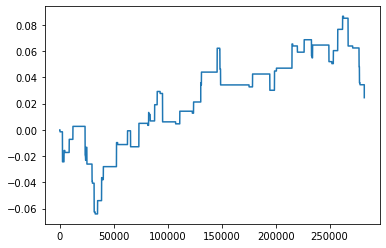

In [603]:
plt.plot(equity_value_1)

# response: return

In [752]:
#forecasting 20/10 tick's return using 1~10 ticks

# data preprocessing

In [753]:
#data preprocessing
df = pd.read_csv('./data/3406.csv')
df['spread1'] = df['Ask1'] - df['Bid1']
df['spread2'] = df['Ask2'] - df['Bid2']
df['spread3'] = df['Ask3'] - df['Bid3']
df['spread4'] = df['Ask4'] - df['Bid4']
df['spread5'] = df['Ask5'] - df['Bid5']
df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
df['a51_diff'] = df['Ask5'] - df['Ask1']
df['b15_diff'] = df['Bid1'] - df['Bid5']
df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a32_diff_abs'] = np.abs(df['Ask3'] - df['Ask2'])
df['a43_diff_abs'] = np.abs(df['Ask4'] - df['Ask3'])
df['a54_diff_abs'] = np.abs(df['Ask5'] - df['Ask4'])
df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
#1 tick
df['da1_dt_1'] = df['Ask1'] - df['Ask1'].shift(1)
df['da2_dt_1'] = df['Ask2'] - df['Ask2'].shift(1)
df['da3_dt_1'] = df['Ask3'] - df['Ask3'].shift(1)
df['da4_dt_1'] = df['Ask4'] - df['Ask4'].shift(1)
df['da5_dt_1'] = df['Ask5'] - df['Ask5'].shift(1)
df['db1_dt_1'] = df['Bid1'] - df['Bid1'].shift(1)
df['db2_dt_1'] = df['Bid2'] - df['Bid2'].shift(1)
df['db3_dt_1'] = df['Bid3'] - df['Bid3'].shift(1)
df['db4_dt_1'] = df['Bid4'] - df['Bid4'].shift(1)
df['db5_dt_1'] = df['Bid5'] - df['Bid5'].shift(1)
#5 ticks
df['da1_dt_5'] = df['Ask1'] - df['Ask1'].shift(5)
df['da2_dt_5'] = df['Ask2'] - df['Ask2'].shift(5)
df['da3_dt_5'] = df['Ask3'] - df['Ask3'].shift(5)
df['da4_dt_5'] = df['Ask4'] - df['Ask4'].shift(5)
df['da5_dt_5'] = df['Ask5'] - df['Ask5'].shift(5)
df['db1_dt_5'] = df['Bid1'] - df['Bid1'].shift(5)
df['db2_dt_5'] = df['Bid2'] - df['Bid2'].shift(5)
df['db3_dt_5'] = df['Bid3'] - df['Bid3'].shift(5)
df['db4_dt_5'] = df['Bid4'] - df['Bid4'].shift(5)
df['db5_dt_5'] = df['Bid5'] - df['Bid5'].shift(5)
##10 ticks
df['da1_dt_10'] = df['Ask1'] - df['Ask1'].shift(10)
df['da2_dt_10'] = df['Ask2'] - df['Ask2'].shift(10)
df['da3_dt_10'] = df['Ask3'] - df['Ask3'].shift(10)
df['da4_dt_10'] = df['Ask4'] - df['Ask4'].shift(10)
df['da5_dt_10'] = df['Ask5'] - df['Ask5'].shift(10)
df['db1_dt_10'] = df['Bid1'] - df['Bid1'].shift(10)
df['db2_dt_10'] = df['Bid2'] - df['Bid2'].shift(10)
df['db3_dt_10'] = df['Bid3'] - df['Bid3'].shift(10)
df['db4_dt_10'] = df['Bid4'] - df['Bid4'].shift(10)
df['db5_dt_10'] = df['Bid5'] - df['Bid5'].shift(10)
#1 tick
df['daq1_dt_1'] = df['AskQty1'] - df['AskQty1'].shift(1)
df['daq2_dt_1'] = df['AskQty2'] - df['AskQty2'].shift(1)
df['daq3_dt_1'] = df['AskQty3'] - df['AskQty3'].shift(1)
df['daq4_dt_1'] = df['AskQty4'] - df['AskQty4'].shift(1)
df['daq5_dt_1'] = df['AskQty5'] - df['AskQty5'].shift(1)
df['dbq1_dt_1'] = df['BidQty1'] - df['BidQty1'].shift(1)
df['dbq2_dt_1'] = df['BidQty2'] - df['BidQty2'].shift(1)
df['dbq3_dt_1'] = df['BidQty3'] - df['BidQty3'].shift(1)
df['dbq4_dt_1'] = df['BidQty4'] - df['BidQty4'].shift(1)
df['dbq5_dt_1'] = df['BidQty5'] - df['BidQty5'].shift(1)
#5 ticks
df['daq1_dt_5'] = df['AskQty1'] - df['AskQty1'].shift(5)
df['daq2_dt_5'] = df['AskQty2'] - df['AskQty2'].shift(5)
df['daq3_dt_5'] = df['AskQty3'] - df['AskQty3'].shift(5)
df['daq4_dt_5'] = df['AskQty4'] - df['AskQty4'].shift(5)
df['daq5_dt_5'] = df['AskQty5'] - df['AskQty5'].shift(5)
df['dbq1_dt_5'] = df['BidQty1'] - df['BidQty1'].shift(5)
df['dbq2_dt_5'] = df['BidQty2'] - df['BidQty2'].shift(5)
df['dbq3_dt_5'] = df['BidQty3'] - df['BidQty3'].shift(5)
df['dbq4_dt_5'] = df['BidQty4'] - df['BidQty4'].shift(5)
df['dbq5_dt_5'] = df['BidQty5'] - df['BidQty5'].shift(5)
#10 ticks
df['daq1_dt_10'] = df['AskQty1'] - df['AskQty1'].shift(10)
df['daq2_dt_10'] = df['AskQty2'] - df['AskQty2'].shift(10)
df['daq3_dt_10'] = df['AskQty3'] - df['AskQty3'].shift(10)
df['daq4_dt_10'] = df['AskQty4'] - df['AskQty4'].shift(10)
df['daq5_dt_10'] = df['AskQty5'] - df['AskQty5'].shift(10)
df['dbq1_dt_10'] = df['BidQty1'] - df['BidQty1'].shift(10)
df['dbq2_dt_10'] = df['BidQty2'] - df['BidQty2'].shift(10)
df['dbq3_dt_10'] = df['BidQty3'] - df['BidQty3'].shift(10)
df['dbq4_dt_10'] = df['BidQty4'] - df['BidQty4'].shift(10)
df['dbq5_dt_10'] = df['BidQty5'] - df['BidQty5'].shift(10)
#response 放在最後一行
df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
#drop nan
df = df.dropna()
df = df.reset_index(drop = True)
#b43_diff_abs and b54_diff_abs are all same values -> drop
#df = df.drop(['b43_diff_abs'], axis = 1)
#df = df.drop(['b54_diff_abs'], axis = 1)
from datetime import datetime
df['TxTime'] = pd.to_datetime(df['TxTime'])
df['TxTime'] = [str(x)[0:10] for x in df['TxTime']]
#some index's ask1 = 0, we change that mid1 to bid1
idx = df[df['Ask1'] == 0].index
for i in idx:
    df['mid1'].iloc[i] = df['Bid1'].iloc[i]
#3/23 3/24 data有缺值 -> drop
df = df[df['TxTime'] != '2020-03-23']
df = df[df['TxTime'] != '2020-03-24']
df = df.reset_index(drop = True)
df['return_10t'] = df['mid1'].shift(-10) / df['mid1'] -1
#1~10 predict 20/10的 return -> 11買賣 -> shift(1)
df['return_10t'] = df['return_10t'].shift(1)
#後9筆nan drop掉
df = df.iloc[0:386561]
#drop TxTime
df2 = df.drop(['TxTime'], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [754]:
#colab notebook: lstm_return_10

In [755]:
train_return10 = pd.read_csv('./data/train_return_10.csv')
test_return10 = pd.read_csv('./data/test_return_10.csv')

In [758]:
train_return10['0']

0         0.003231
1         0.002147
2         0.001143
3         0.000737
4         0.000928
            ...   
282236    0.000088
282237    0.000074
282238    0.000168
282239    0.000166
282240    0.000110
Name: 0, Length: 282241, dtype: float64

In [763]:
#已實現損益
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#未實現損益
df['unrealized'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df['holding'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df_test = df.iloc[282251: ]
df_train = df.iloc[0:282251]
#0~9 pred 10, hence start from 10
df_train = df_train.iloc[10:, :]
df_test = df_test.iloc[10:, :]
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
#pred return
df_train['pred_return'] = train_return10[['0']]
df_test['pred_return'] = test_return10[['0']]

In [764]:
df_train

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1,return_10t,equity_value,unrealized,holding,pred_return
0,397.0,1,2,396.5,397.0,3,6,396.0,398.0,20,...,5.0,34.0,-31.0,-8.0,396.75,0.003781,0.0,0.0,0.0,0.003231
1,397.0,1,2,396.5,397.0,2,6,396.0,398.0,20,...,0.0,0.0,0.0,0.0,396.75,0.001260,0.0,0.0,0.0,0.002147
2,396.5,2,6,396.0,397.0,2,40,395.0,398.0,20,...,34.0,-31.0,-8.0,5.0,396.50,0.001260,0.0,0.0,0.0,0.001143
3,397.0,2,6,396.0,397.0,0,40,395.0,398.0,20,...,34.0,-31.0,-8.0,5.0,396.50,0.001892,0.0,0.0,0.0,0.000737
4,398.0,20,6,396.0,397.0,0,40,395.0,398.0,20,...,34.0,-31.0,-8.0,5.0,396.50,0.001892,0.0,0.0,0.0,0.000928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282236,0.0,0,16,460.5,461.0,22,16,460.0,461.5,11,...,-2.0,0.0,0.0,0.0,460.75,-0.007054,0.0,0.0,0.0,0.000088
282237,0.0,0,16,460.5,461.0,21,16,460.0,461.5,11,...,-2.0,0.0,0.0,0.0,460.75,-0.007054,0.0,0.0,0.0,0.000074
282238,460.5,1,15,460.5,461.0,21,16,460.0,461.5,11,...,-2.0,0.0,0.0,0.0,460.75,-0.007054,0.0,0.0,0.0,0.000168
282239,461.0,1,15,460.5,461.0,20,16,460.0,461.5,11,...,-2.0,0.0,0.0,0.0,460.75,-0.007054,0.0,0.0,0.0,0.000166


In [765]:
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1,return_10t,equity_value,unrealized,holding,pred_return
0,0.0,0,2,457.5,458.0,10,10,457.0,458.5,5,...,-4.0,-27.0,38.0,-11.0,457.75,-0.000546,0.0,0.0,0.0,-0.000019
1,457.5,1,1,457.5,458.0,10,10,457.0,458.5,5,...,-4.0,-27.0,38.0,-11.0,457.75,0.000000,0.0,0.0,0.0,-0.000105
2,0.0,0,1,457.5,458.0,12,10,457.0,458.5,5,...,-1.0,0.0,0.0,0.0,457.75,0.000000,0.0,0.0,0.0,-0.000153
3,0.0,0,1,457.5,458.0,12,10,457.0,458.5,5,...,0.0,0.0,0.0,0.0,457.75,0.001092,0.0,0.0,0.0,-0.000099
4,0.0,0,1,457.5,458.0,12,9,457.0,458.5,5,...,-5.0,-27.0,38.0,-11.0,457.75,0.000000,0.0,0.0,0.0,-0.000117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104295,0.0,0,25,443.0,443.5,1,10,442.5,444.0,1,...,0.0,0.0,2.0,0.0,443.25,0.001128,0.0,0.0,0.0,0.000456
104296,443.5,1,1,443.5,444.0,1,25,443.0,444.5,23,...,15.0,-9.0,12.0,-11.0,443.75,0.001128,0.0,0.0,0.0,0.000460
104297,0.0,0,6,443.5,444.0,1,25,443.0,444.5,23,...,15.0,-9.0,12.0,-11.0,443.75,0.000000,0.0,0.0,0.0,0.000057
104298,0.0,0,6,443.5,444.0,2,25,443.0,444.5,23,...,15.0,-9.0,12.0,-11.0,443.75,0.000000,0.0,0.0,0.0,0.000229


In [768]:
np.sum(df_train['pred_return'] > 0.002)

48

In [769]:
np.sum(df_train['pred_return'] > 0.001)

363

In [773]:
np.sum(df_train['pred_return'] > 0.0015)

103

In [770]:
np.sum(df_train['pred_return'] < -0.002)

14

In [771]:
np.sum(df_train['pred_return'] < -0.001)

156

In [772]:
np.sum(df_train['pred_return'] < -0.0015)

42

In [774]:
#setting parameters
import itertools 
long_side, short_side, stop_1 = [0.001, 0.0015, 0.002], [-0.001, -0.0015, -0.002], [-0.01, -0.015, -0.02, -0.025]
paras = list(itertools.product(long_side, short_side, stop_1))
paras

[(0.001, -0.001, -0.01),
 (0.001, -0.001, -0.015),
 (0.001, -0.001, -0.02),
 (0.001, -0.001, -0.025),
 (0.001, -0.0015, -0.01),
 (0.001, -0.0015, -0.015),
 (0.001, -0.0015, -0.02),
 (0.001, -0.0015, -0.025),
 (0.001, -0.002, -0.01),
 (0.001, -0.002, -0.015),
 (0.001, -0.002, -0.02),
 (0.001, -0.002, -0.025),
 (0.0015, -0.001, -0.01),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.001, -0.02),
 (0.0015, -0.001, -0.025),
 (0.0015, -0.0015, -0.01),
 (0.0015, -0.0015, -0.015),
 (0.0015, -0.0015, -0.02),
 (0.0015, -0.0015, -0.025),
 (0.0015, -0.002, -0.01),
 (0.0015, -0.002, -0.015),
 (0.0015, -0.002, -0.02),
 (0.0015, -0.002, -0.025),
 (0.002, -0.001, -0.01),
 (0.002, -0.001, -0.015),
 (0.002, -0.001, -0.02),
 (0.002, -0.001, -0.025),
 (0.002, -0.0015, -0.01),
 (0.002, -0.0015, -0.015),
 (0.002, -0.0015, -0.02),
 (0.002, -0.0015, -0.025),
 (0.002, -0.002, -0.01),
 (0.002, -0.002, -0.015),
 (0.002, -0.002, -0.02),
 (0.002, -0.002, -0.025)]

In [775]:
#main strategy

In [776]:
#adding hard stop 
#main strategy (train set)
#record transaction
transaction_history1 = {}
#record equity values
equity_value_1 = pd.DataFrame()
#record each returns
each_return1 = pd.DataFrame()
#record unrealized gain
unrealized_1 = pd.DataFrame()
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['pred_return'].iloc[j] > paras[l][0]:
            #long side
            df_train['side'].iloc[j] = 1
        elif df_train['pred_return'].iloc[j] < paras[l][1]:
            #short side
            df_train['side'].iloc[j] = -1
    date_idx = df_train['TxTime'].unique()
    #紀錄已實現
    equity_value1 = pd.DataFrame()
    #紀錄未實現
    unrealized1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
        unrealized1 = pd.concat([unrealized1, df['unrealized']])
    #concat
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site

In [811]:
performance(equity_value_1[[(0.002, -0.001, -0.025)]], transaction_history1[(0.002, -0.001, -0.025)])

return: 0.04026499194878
std: 0.028689956349764473
sharp ratio: 1.2222044370265437
trades: 38.0
odds ratio: 0.47368421052631576
mdd: 0.08365188248118982
skewness: 0.3737909572230477


(0.04026499194878,
 0.028689956349764473,
 1.2222044370265437,
 38.0,
 0.47368421052631576,
 0.08365188248118982,
 0.3737909572230477)

In [789]:
profit_col = equity_value_1.iloc[-1][equity_value_1.iloc[-1] > 0].index.tolist()

In [793]:
total_return_1 = equity_value_1[profit_col]

In [794]:
total_return_1

,"(0.001, -0.002, -0.015)","(0.001, -0.002, -0.02)","(0.0015, -0.001, -0.02)","(0.0015, -0.001, -0.025)","(0.002, -0.001, -0.015)","(0.002, -0.001, -0.02)","(0.002, -0.001, -0.025)"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
282236,-0.000346,0.004664,0.012748,0.028262,0.005448,0.029268,0.040265
282237,-0.000346,0.004664,0.012748,0.028262,0.005448,0.029268,0.040265
282238,-0.000346,0.004664,0.012748,0.028262,0.005448,0.029268,0.040265
282239,-0.000346,0.004664,0.012748,0.028262,0.005448,0.029268,0.040265


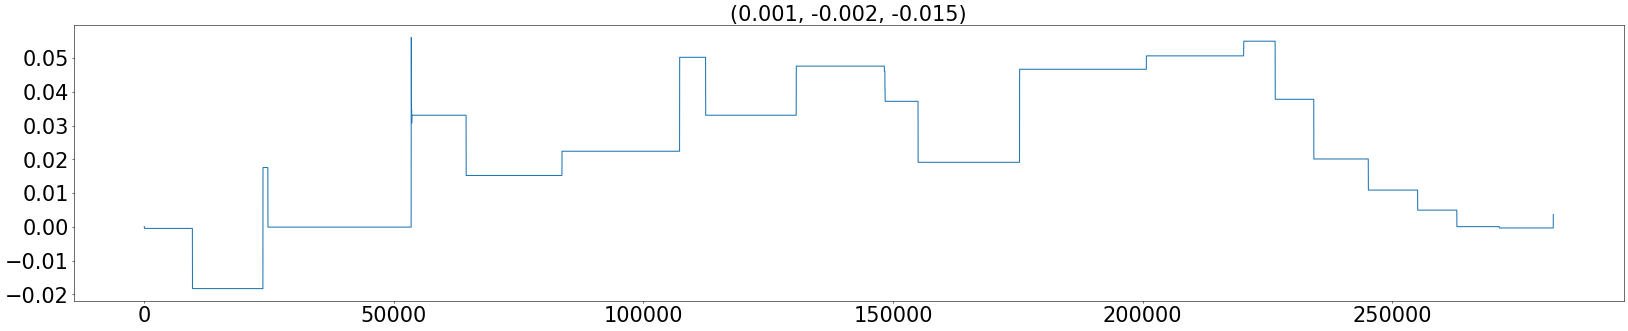

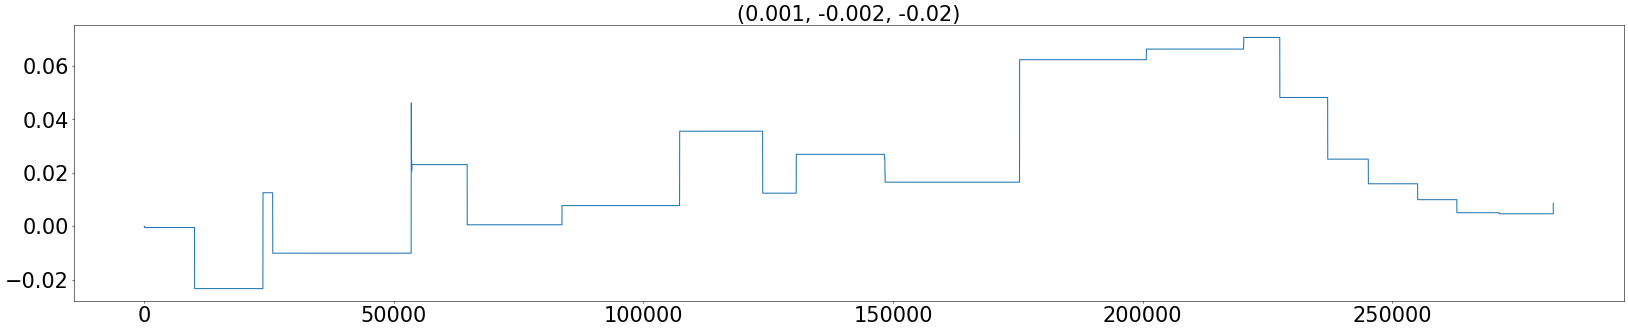

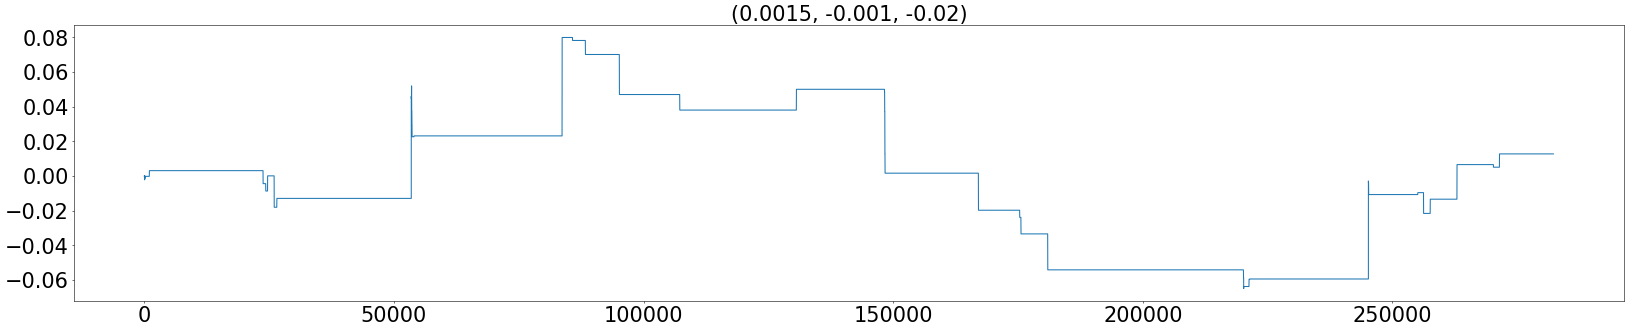

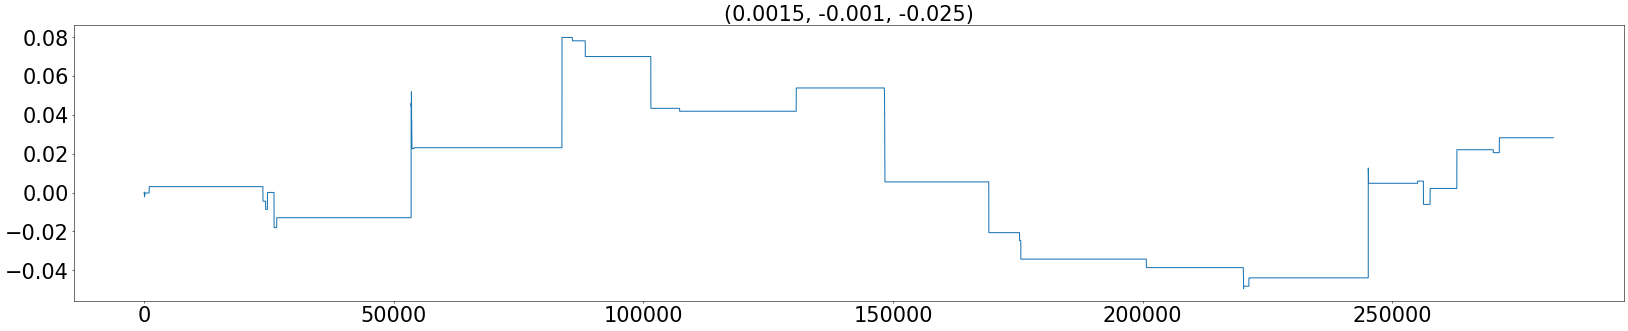

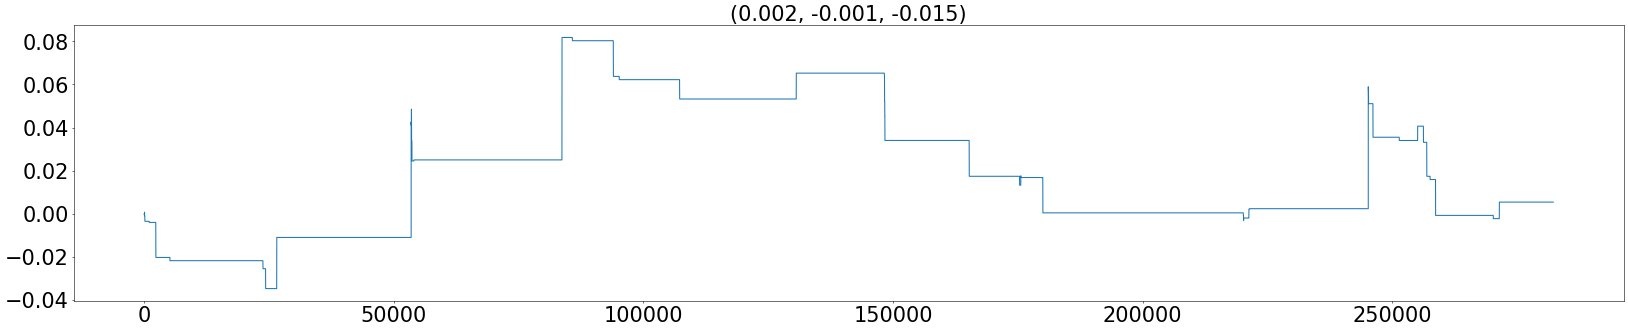

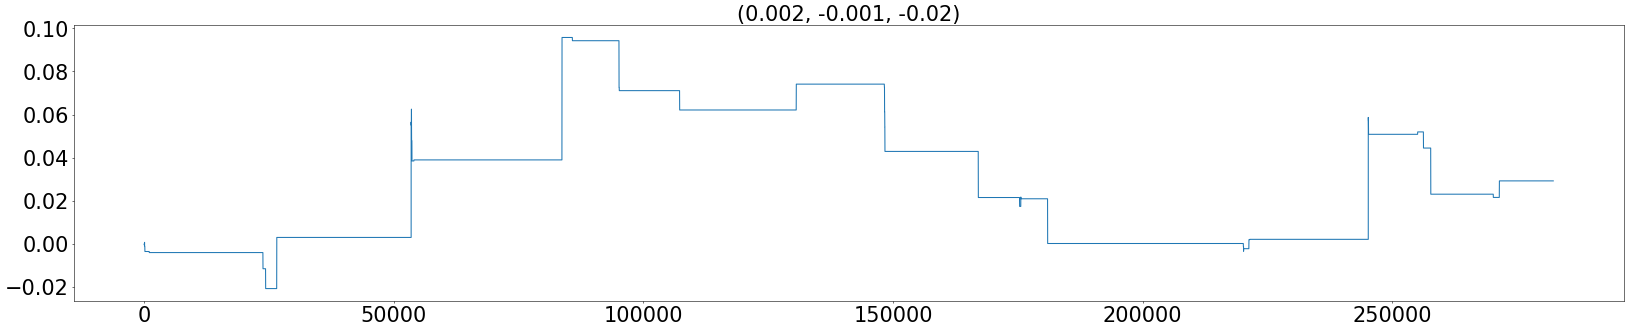

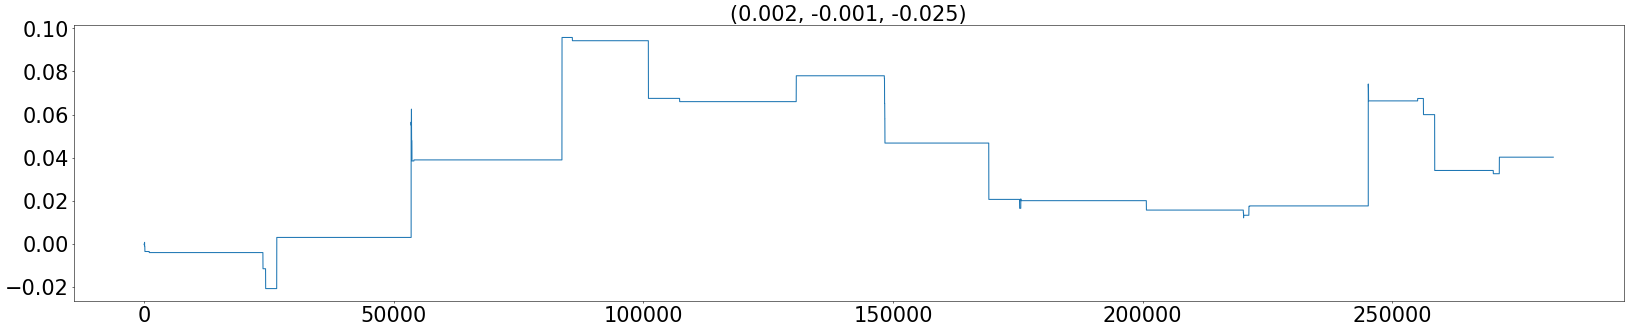

In [816]:
for i in range(len(profit_col)):
    plt.figure(figsize=(40,60),dpi=50)
    plt.subplot(7, 1, i+1)
    plt.plot(total_return_1[profit_col[i]])
    plt.title(profit_col[i], fontsize = 30)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)

In [806]:
#adding hard stop 
#main strategy (test set)
#record transaction
transaction_history2 = {}
#record equity values
equity_value_2 = pd.DataFrame()
#record each returns
each_return2 = pd.DataFrame()
#record unrealized gain
unrealized_2 = pd.DataFrame()
for l in range(len(profit_col)):
    df_test['side'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
    for j in range(len(df_test)):
        if df_test['pred_return'].iloc[j] > profit_col[l][0]:
            #long side
            df_test['side'].iloc[j] = 1
        elif df_test['pred_return'].iloc[j] < profit_col[l][1]:
            #short side
            df_test['side'].iloc[j] = -1
    date_idx = df_test['TxTime'].unique()
    #紀錄已實現
    equity_value2 = pd.DataFrame()
    #紀錄未實現
    unrealized2 = pd.DataFrame()
    for k in date_idx:
        df = df_test[df_test.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history2[profit_col[l]][-1]['Price'] - 1) < profit_col[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history2)
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1) < profit_col[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value2 = pd.concat([equity_value2, df[['equity_value']]])
        unrealized2 = pd.concat([unrealized2, df['unrealized']])
    #concat
    equity_value_2 = pd.concat([equity_value_2, np.cumsum(equity_value2)], axis = 1)
    each_return2 = pd.concat([each_return2, equity_value2], axis = 1)
    unrealized_2 = pd.concat([unrealized_2, unrealized2], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

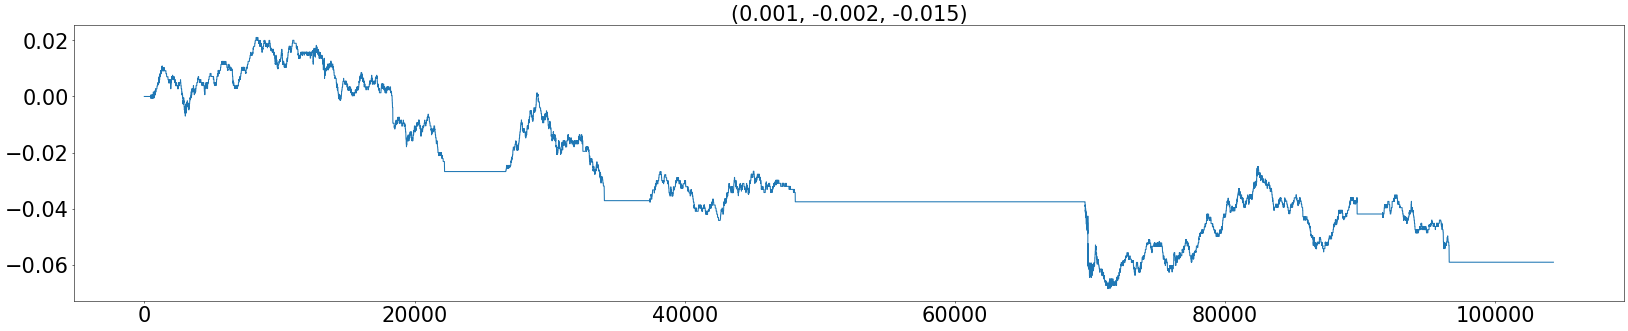

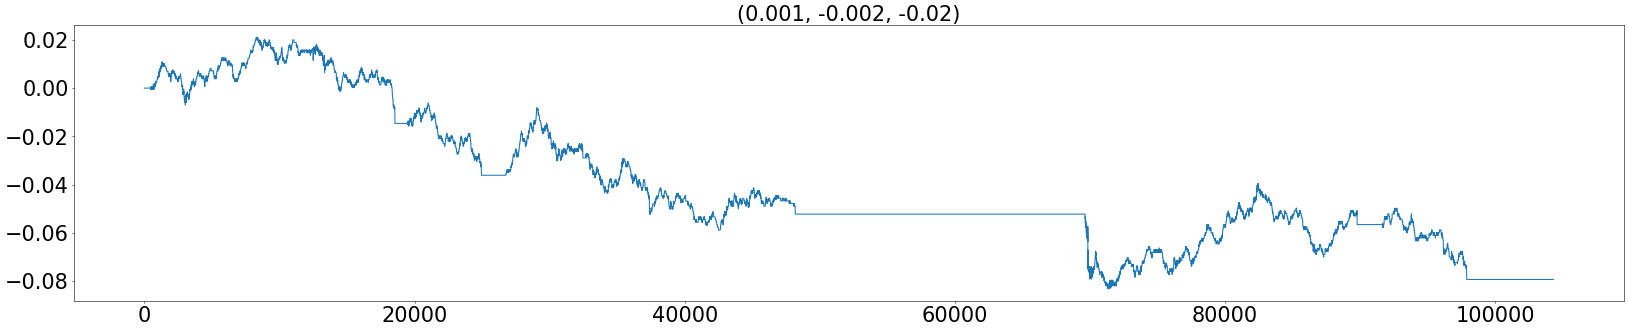

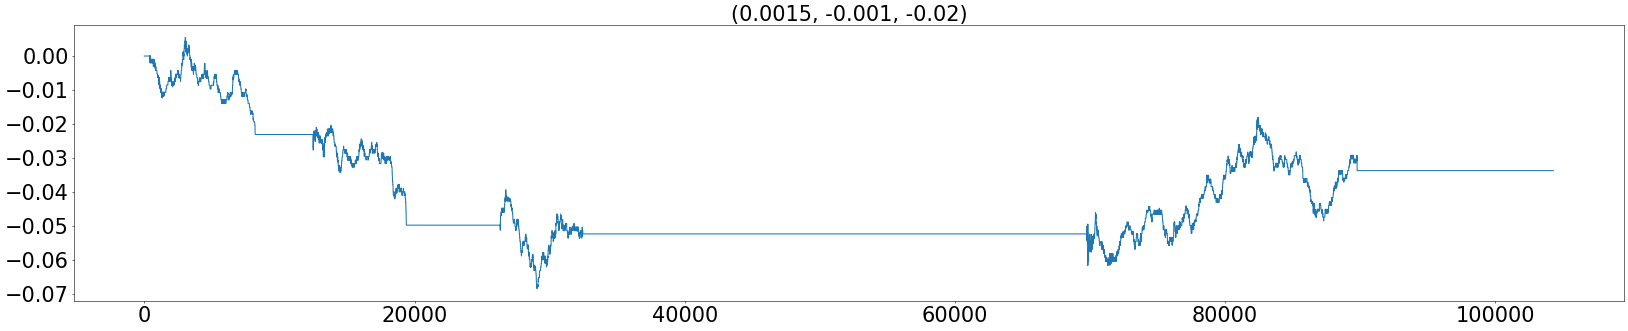

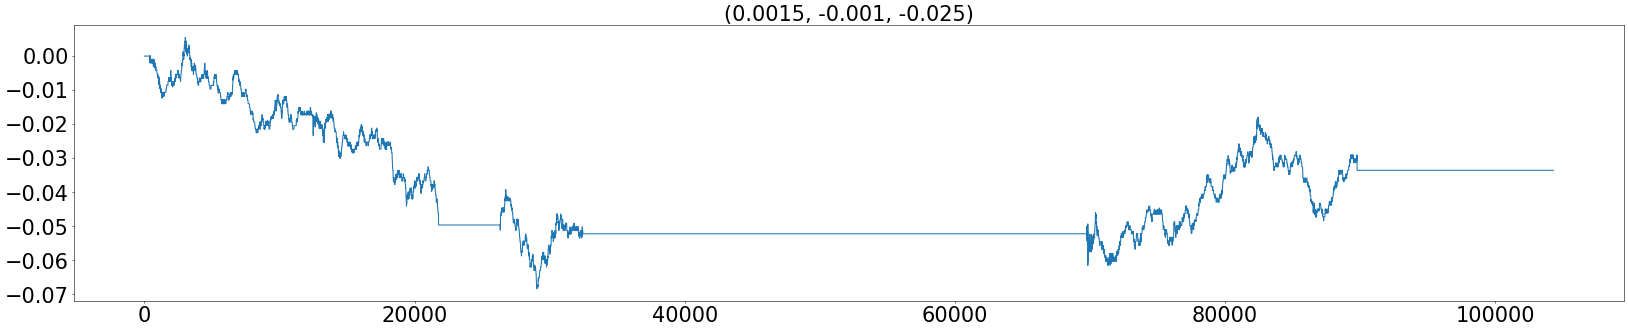

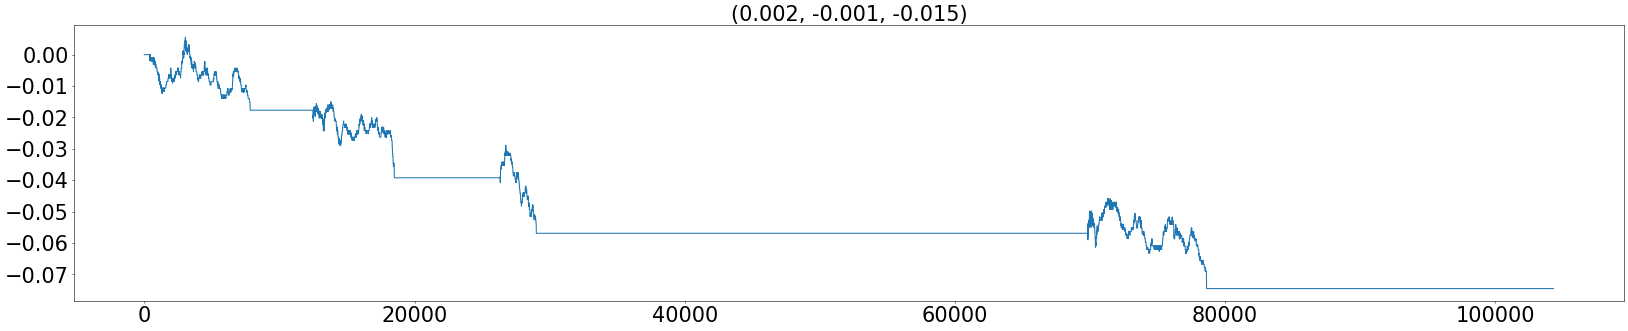

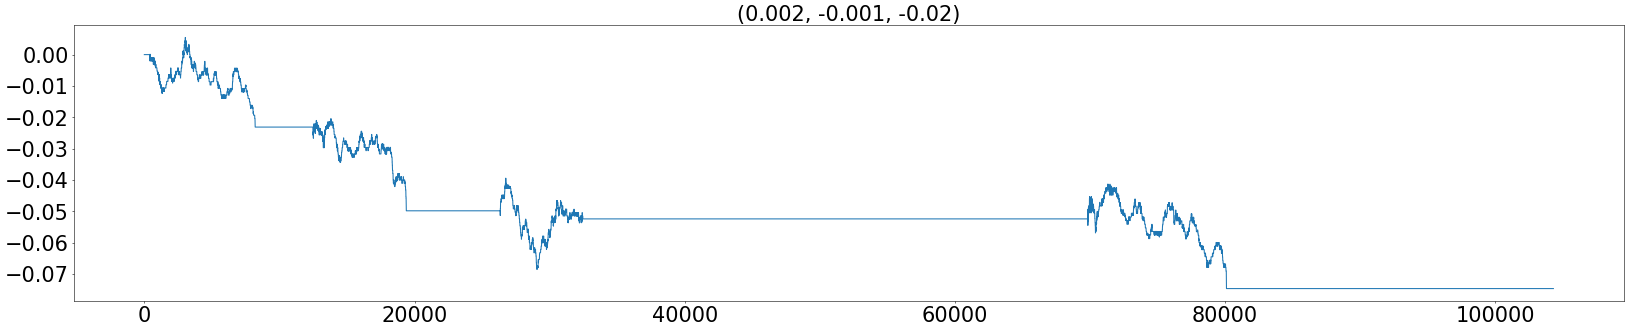

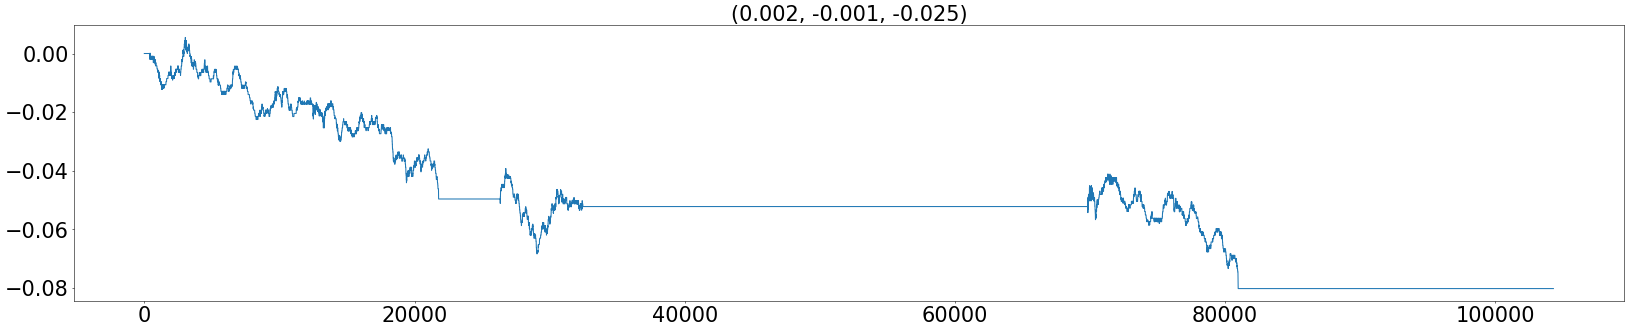

In [815]:
for k in range(len(profit_col)):
    r_idx = (each_return2.iloc[:, k][each_return2.iloc[:, k] != 0]).index.tolist()
    #將realized gain補進去
    for i in r_idx:
        unrealized_2.iloc[i, k] = equity_value_2['equity_value'].iloc[i, k]
    r_idx.insert(0,0)
    unrealized_df = pd.DataFrame()
    for j in range(len(r_idx) - 1):
        unrealized_df = pd.concat([unrealized_df, np.cumsum(unrealized_2.iloc[r_idx[j]:r_idx[j+1], k])], axis = 0)
    unrealized_df = pd.concat([unrealized_df, equity_value_2['equity_value'].iloc[r_idx[-1]:, k]], axis = 0)
    unrealized_df = unrealized_df.reset_index(drop = True)
    #print(profit_col[k])
    plt.figure(figsize=(40,60),dpi=50)
    plt.subplot(7, 1, k+1)
    plt.plot(unrealized_df)
    plt.title(profit_col[k], fontsize = 30)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)

In [809]:
equity_value_2

,equity_value,equity_value,equity_value,equity_value,equity_value,equity_value,equity_value
0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
...,...,...,...,...,...,...,...
104295,-0.058989,-0.079362,-0.033731,-0.033548,-0.07451,-0.07458,-0.080151
104296,-0.058989,-0.079362,-0.033731,-0.033548,-0.07451,-0.07458,-0.080151
104297,-0.058989,-0.079362,-0.033731,-0.033548,-0.07451,-0.07458,-0.080151
104298,-0.058989,-0.079362,-0.033731,-0.033548,-0.07451,-0.07458,-0.080151


In [818]:
equity_value_2.columns = profit_col
performance(equity_value_2[[(0.002, -0.001, -0.025)]], transaction_history2[(0.002, -0.001, -0.025)])

return: -0.08015105632666414
std: 0.02360603389343084
sharp ratio: -3.6156457587064588
trades: 7.0
odds ratio: 0.14285714285714285
mdd: 0.08015105632666414
skewness: 0.6791382354834434


(-0.08015105632666414,
 0.02360603389343084,
 -3.6156457587064588,
 7.0,
 0.14285714285714285,
 0.08015105632666414,
 0.6791382354834434)

In [1]:
import scipy

ModuleNotFoundError: No module named 'scipy._lib'